## Analyse de la segmentation des mitochondries dans des images obtenues par microscopie électronique.

In [1]:
import pandas as pd
import numpy as np
import warnings
import io
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
import numpy as np
import warnings
import io
from PIL import Image, ImageOps, ImageFilter
import random



2024-10-04 21:51:16.142918: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 21:51:16.155059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 21:51:16.166461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 21:51:16.169337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 21:51:16.179682: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class Utils:
    def apply_to_element_or_list(index):
        def decorator(func):
            def wrapper(*args, **kwargs):
                parameter_target = args[index]
                if isinstance(parameter_target, list):
                    return [func(*args[:index], element_target, *args[index+1:], **kwargs) for element_target in args[index]]
                return func(*args, **kwargs)
            return wrapper
        return decorator
    
    @staticmethod
    def display_images(images, titles):
        num_images = len(images)
        
        if num_images != 3:
            raise ValueError(f"Required 3 images in images, actual length: {num_images}")
        
        if len(titles) != 3:
            raise ValueError(f"Required 3 titles in titles, actual length: {len(titles)}")

        fig, axes = plt.subplots(1, 3, figsize=(10, 3))

        for i in range(num_images):
            axes[i].imshow(images[i] * 255, cmap='gray', vmin=0, vmax=255)
            axes[i].set_title(titles[i])
            axes[i].axis('off')

        plt.show()


In [3]:
class Preprocessing:
    @staticmethod
    @Utils.apply_to_element_or_list(0)
    def bytes_to_grayscale_np_array(byte_image_list):
        if not Preprocessing.validate_data(byte_image_list, expected_ndim=1, expected_keys=['bytes']):
            return
        
        grayscale_images = []
        for byte_image in byte_image_list:
            image_stream = io.BytesIO(byte_image['bytes'])
            image = Image.open(image_stream).convert("L")
            grayscale_array = np.array(image)
            grayscale_images.append(grayscale_array)
            
        return np.array(grayscale_images)

    def __init__(self, name, config):
        self.name = name
        self.normalize_config = config['normalize_config']
        self.scale = config.get('scale', (64, 64))
        self.downsample_method = config['downsample_method']
        self.histogram_equalization = config.get('histogram_equalization', False)
        self.gaussian_blur = config.get('gaussian_blur', False)
        self.invert_colors = config.get('invert_colors', False)
        self.data_augmentation = config.get('data_augmentation', False)
        self.processed_data = None

    @staticmethod
    def validate_data(data, expected_ndim, expected_keys=None):
        if not isinstance(data, np.ndarray):
            print(data)
            warnings.warn("Input must be a NumPy array.", UserWarning)
            return False

        if data.ndim != expected_ndim:
            warnings.warn(f"Array must have {expected_ndim} dimensions. Current shape: {data.shape}", UserWarning)
            return False

        if len(data) == 0:
            warnings.warn("Array length must be greater than zero.", UserWarning)
            return False

        if expected_keys:
            if not isinstance(data[0], dict) or not all(key in data[0] for key in expected_keys):
                warnings.warn(f"Array elements must be dictionaries containing the keys: {expected_keys}", UserWarning)
                return False

        return True

    def process(self, x_train, y_train, x_test, y_test):
        if not Preprocessing.validate_data(x_train, expected_ndim=3) or not Preprocessing.validate_data(y_train, expected_ndim=3):
            return
        
        x_train = self.downsample(x_train)
        y_train = self.downsample(y_train)
        x_test = self.downsample(x_test)
        y_test = self.downsample(y_test)
        
        if self.histogram_equalization:
            x_train, x_test = self.apply_histogram_equalization([x_train, x_test])

        if self.invert_colors:
            x_train, x_test = self.apply_invert_colors([x_train, x_test])

        if self.normalize_config['to_normalize']:
            x_train, y_train, x_test, y_test = self.apply_threshold([x_train, y_train, x_test, y_test])
        
        return x_train, y_train, x_test, y_test

    @Utils.apply_to_element_or_list(1)
    def apply_threshold(self, image_array):
        threshold = self.normalize_config['threshold']
        return (image_array > threshold).astype(np.uint8)

    @Utils.apply_to_element_or_list(1)
    def apply_histogram_equalization(self, image_array):
        equalized_images = []
        for img in image_array:
            pil_image = Image.fromarray(img)
            equalized_image = ImageOps.equalize(pil_image)
            equalized_images.append(np.array(equalized_image))
        return np.array(equalized_images)

    @Utils.apply_to_element_or_list(1)
    def apply_invert_colors(self, image_array):
        inverted_images = []
        for img in image_array:
            pil_image = Image.fromarray(img)
            inverted_image = ImageOps.invert(pil_image)
            inverted_images.append(np.array(inverted_image))
        return np.array(inverted_images)

    def downsample(self, image_array):
        target_size = self.scale
        downsampled_images = []
        
        for img in image_array:
            pil_image = Image.fromarray(img)
            downsampled_image = pil_image.resize(target_size, self.downsample_method)
            downsampled_images.append(np.array(downsampled_image))
        
        return np.array(downsampled_images)


In [4]:
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, config):
        super(ConvolutionalAutoencoder, self).__init__()
        
        num_layers = config['num_layers']
        kernel_size = config['kernel_size']
        in_channels = 1
        
        assert num_layers >= 2, "Le nombre de couches doit être au moins 2."
        assert kernel_size in {1, 3, 5, 7, 9}, "Le kernel_size doit être 1, 3, 5, 7 ou 9"

        padding = kernel_size // 2

        self.enc_layers = nn.ModuleList()
        self.dec_layers = nn.ModuleList()

        for i in range(num_layers // 2):
            out_channels = max(i * 8, 1)
            self.enc_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            in_channels = out_channels
        
        if num_layers % 2 != 0:
            self.middle_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding)
        else:
            self.middle_layer = None

        for i in range(num_layers // 2, 0, -1):
            out_channels = max(1, (i - 1) * 8)
            self.dec_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.enc_layers:
            x = F.relu(layer(x))
        
        if self.middle_layer is not None:
            x = F.relu(self.middle_layer(x))

        for layer in self.dec_layers[:-1]:
            x = F.relu(layer(x))
        
        return self.dec_layers[-1](x)

In [5]:
class Model:
    def __init__(self, name, config):
        self.name = name
        self.config = config
        self._model = None

    def build_model(self):
        model_type = self.config['type']
        if model_type == 'convolutional_autoencoder':
            self._model = ConvolutionalAutoencoder(self.config)
        else:
            raise ValueError(f"Model type {model_type} not supported")


In [6]:
def jaccard_index(preds, labels, smooth=1e-6):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.float()
    labels = labels.float()
    
    intersection = (preds * labels).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + labels.sum(dim=(1,2,3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def dice_coefficient(preds, labels, smooth=1e-6):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.float()
    labels = labels.float()
    
    intersection = (preds * labels).sum(dim=(1,2,3))
    dice = (2. * intersection + smooth) / (preds.sum(dim=(1,2,3)) + labels.sum(dim=(1,2,3)) + smooth)
    return dice.mean()


In [7]:
class Training:
    def __init__(self, name, config, log_dir):
        self.name = name
        self.config = config
        self.loss_function_class = config['loss_function_class']
        self.optimizer_name = config['optimizer_name']
        self.metrics = config['metrics']
        self.epochs = config['epochs']
        self.device = torch.device('cpu')
        self.log_dir = log_dir
        self.writer = SummaryWriter(f"{self.log_dir}/{self.name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}")

    def set_model(self, model):
        """Set the model, loss function, and optimizer for the training."""
        self.model = model.to(self.device)
        self.loss_function = self.loss_function_class()
        self.learning_rate = self.config['learning_rate']
        if self.optimizer_name == 'adam':
            self.optimizer = self.config.get('optimizer', optim.Adam(self.model.parameters(), lr=self.learning_rate))
        else:
            raise ValueError(f"Unsupported optimizer: {self.optimizer_name}")

    def train_step(self, x_batch, y_batch):
        x_batch = x_batch.float()
        y_batch = y_batch.float()

        self.model.train()
        x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
        self.optimizer.zero_grad()
        y_pred = self.model(x_batch)
        loss = self.loss_function(y_pred, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item(), y_pred

    def train(self, train_loader):
        """Boucle principale d'entraînement."""
        total_start_time = time.time()
        for epoch in range(self.epochs):
            epoch_start_time = time.time()
            total_loss = 0
            for i, (x_batch, y_batch) in enumerate(train_loader):
                loss, y_pred = self.train_step(x_batch, y_batch)
                total_loss += loss

                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y_batch)
                    self.writer.add_scalar(f"Metric/{metric_fn.__name__}", metric_value, epoch * len(train_loader) + i)

            avg_loss = total_loss / len(train_loader)
            self.writer.add_scalar("Loss/train", avg_loss, epoch)

            epoch_elapsed_time = time.time() - epoch_start_time
            total_elapsed_time = time.time() - total_start_time

            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}, "
                f"Epoch Time: {epoch_elapsed_time:.2f}s, Total Time Elapsed: {total_elapsed_time:.2f}s")

        self.writer.close()

    def evaluate(self, test_loader):
        """Evaluate the model on the test set."""
        self.model.eval()
        total_loss = 0
        all_metrics = {metric_fn.__name__: 0 for metric_fn in self.metrics}
        
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                y_pred = self.model(x_batch)
                loss = self.loss_function(y_pred, y_batch)
                total_loss += loss.item()

                for metric_fn in self.metrics:
                    all_metrics[metric_fn.__name__] += metric_fn(y_pred, y_batch)

        avg_loss = total_loss / len(test_loader)
        print(f"Test Loss: {avg_loss:.4f}")
        for metric_name, total_metric_value in all_metrics.items():
            avg_metric = total_metric_value / len(test_loader)
            print(f"{metric_name}: {avg_metric:.4f}")
        print()
        
        return avg_loss, all_metrics


In [8]:
class Pipeline:
    def __init__(self, data, pipeline_config, preprocessing_configs, model_configs, training_configs):
        self.pipeline_config = pipeline_config
        self.preprocessing_configs = preprocessing_configs
        self.model_configs = model_configs
        self.training_configs = training_configs
        self.x_train, self.y_train, self.x_test, self.y_test = Preprocessing.bytes_to_grayscale_np_array(data)
        self.data_preprocessed_set = {}
        self.model_set = {}
        self.training_set = {}
        self.preprocess_data()
    
    def preprocess_data(self):
        for config_name, config in self.pipeline_config.items():
            preprocessing_name = config['preprocessing_name']
            if preprocessing_name not in self.data_preprocessed_set:
                preprocessing = Preprocessing(preprocessing_name, self.preprocessing_configs[preprocessing_name])
                p_x_train, p_y_train, p_x_test, p_y_test = preprocessing.process(
                    self.x_train, self.y_train, self.x_test, self.y_test
                )
                self.data_preprocessed_set[preprocessing_name] = {
                    "p_x_train": p_x_train,
                    "p_y_train": p_y_train,
                    "p_x_test": p_x_test,
                    "p_y_test": p_y_test
                }

    def initialize_model(self, model_name):
        model_instance = Model(model_name, self.model_configs[model_name])
        model_instance.build_model()
        return model_instance

    def initialize_training(self, config_name, preprocessing_name, model_name, training_name):
        training = Training(training_name, self.training_configs[training_name], f"logs/{config_name}/{preprocessing_name}/{model_name}")
        return training

    def convert_to_tensor(self, data, labels):
        data = [torch.tensor(x, dtype=torch.float32).unsqueeze(0) for x in data]
        labels = [torch.tensor(y, dtype=torch.float32).unsqueeze(0) for y in labels]
        
        return list(zip(data, labels))

    def start(self):
        """Start the entire pipeline process: preprocessing, model training, and evaluation."""
        for config_name, config in self.pipeline_config.items():
            preprocessing_name = config['preprocessing_name']
            model_name = config['model_name']
            training_name = config['training_name']

            data = self.data_preprocessed_set[preprocessing_name]
            p_x_train, p_y_train, p_x_test, p_y_test = data['p_x_train'], data['p_y_train'], data['p_x_test'], data['p_y_test']

            model = self.initialize_model(model_name)

            training = self.initialize_training(config_name, preprocessing_name, model_name, training_name)

            train_data = self.convert_to_tensor(p_x_train, p_y_train)
            test_data = self.convert_to_tensor(p_x_test, p_y_test)
            train_loader = torch.utils.data.DataLoader(
                dataset=train_data,
                batch_size=self.training_configs[training_name]['batch_size'],
                shuffle=True
            )

            test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=self.training_configs[training_name]['batch_size'],
                shuffle=False
            )

            training.set_model(model._model)

            print(f"Starting training for {config_name}...")

            training.train(train_loader)

            self.model_set[model_name] = model
            
            training.evaluate(test_loader)
            
    def display_sample_predictions(self, sample_index=0, train=True):
        for pipeline_name, config in self.pipeline_config.items():
            preprocessing_name = config['preprocessing_name']
            model_name = config['model_name']

            p_x_array = self.data_preprocessed_set[preprocessing_name]['p_x_train' if train else 'p_x_test']
            p_y_array = self.data_preprocessed_set[preprocessing_name]['p_y_train' if train else 'p_y_test']

            x_sample = p_x_array[sample_index]
            y_sample = p_y_array[sample_index]

            x_tensor = torch.tensor(x_sample, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            
            images_to_display = [x_sample, y_sample]
            titles = [f"x_{preprocessing_name}", f"y_{preprocessing_name}", f"y_predict_{pipeline_name}"]

            with torch.no_grad():
                self.model_set[model_name]._model.eval()

                logits = self.model_set[model_name]._model(x_tensor)
                
                prediction = torch.sigmoid(logits) > 0.5
                prediction = prediction.float().squeeze().numpy()
                images_to_display.append(prediction)

                print(f"-------{pipeline_name}---------")
                Utils.display_images(images_to_display, titles)




In [9]:
preprocessing_configs = {
    'binary_thresh_127.5': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 127.5
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': True,
        'gaussian_blur': False,
        'invert_colors': False,
        'data_augmentation': True
    },
    'gaussian_blur_and_invert': {
        'normalize_config': {
            'to_normalize': False
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': False,
        'gaussian_blur': True,
        'invert_colors': True,
        'data_augmentation': False
    }
}

In [10]:
model_configs = {
    'simple_convolutional_autoencoder': {
        'type': 'convolutional_autoencoder',
        'num_layers':7,
        'kernel_size':3
    },
}

In [11]:
metrics = [dice_coefficient, jaccard_index]

training_configs = {
    'try_': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':3,
        'batch_size':30
    },
    'little': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':10,
        'batch_size':30
    },
    'default': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':30,
        'batch_size':300
    },
    'long': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':300,
        'batch_size':50
    },
    'small_batch': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':400,
        'batch_size':10
    }
}

In [12]:
train_df = pd.read_parquet('Electron_microscopy_dataset/train.parquet')
test_df = pd.read_parquet('Electron_microscopy_dataset/test.parquet')

x_train_bytes = train_df['image'].values
y_train_bytes = train_df['label'].values

x_test_bytes = test_df['image'].values
y_test_bytes = test_df['label'].values

print(f"x_train shape: {x_train_bytes.shape}")
print(f"y_train shape: {y_train_bytes.shape}")
print(f"x_test shape: {x_test_bytes.shape}")
print(f"y_test shape: {y_test_bytes.shape}")

data = [x_train_bytes, y_train_bytes, x_test_bytes, y_test_bytes]

x_train shape: (1642,)
y_train shape: (1642,)
x_test shape: (1725,)
y_test shape: (1725,)


In [13]:
preprocessing_configs_compare_time_entry_size = {
    'without_scale': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 127.5
        },
        'scale': (256, 256),
        'downsample_method': Image.BILINEAR
    },
    'with_scale': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 127.5
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR
    }
}

pipeline_configs_compare_time_entry_size = {
    "without_scale": {
        "preprocessing_name":'without_scale',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"try_"
    },
    "with_scale": {
        "preprocessing_name":'with_scale',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"try_"
    }
}


In [14]:
pipeline_compare_time_entry_size = Pipeline(data, pipeline_configs_compare_time_entry_size, preprocessing_configs_compare_time_entry_size, model_configs, training_configs)
pipeline_compare_time_entry_size.start()

Starting training for without_scale...
Epoch [1/3], Loss: 0.2519, Epoch Time: 65.93s, Total Time Elapsed: 65.93s
Epoch [2/3], Loss: 0.1602, Epoch Time: 64.98s, Total Time Elapsed: 130.91s
Epoch [3/3], Loss: 0.1503, Epoch Time: 79.06s, Total Time Elapsed: 209.96s
Test Loss: 0.1405
dice_coefficient: 0.0000
jaccard_index: 0.0000

Starting training for with_scale...
Epoch [1/3], Loss: 0.2092, Epoch Time: 2.12s, Total Time Elapsed: 2.12s
Epoch [2/3], Loss: 0.1315, Epoch Time: 2.21s, Total Time Elapsed: 4.33s
Epoch [3/3], Loss: 0.1305, Epoch Time: 2.16s, Total Time Elapsed: 6.50s
Test Loss: 0.1252
dice_coefficient: 0.0611
jaccard_index: 0.0322



In [15]:
training_configs_learning_rate_choice = {
    'try_low_learning_rate': {
        'optimizer_name':'adam',
        'learning_rate':1e-5,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':10,
        'batch_size':30
    },
    'ideal_learning_rate': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':10,
        'batch_size':30
    },
    'try_high_learning_rate': {
        'optimizer_name':'adam',
        'learning_rate':0.5,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':10,
        'batch_size':30
    }
}

pipeline_configs_learning_rate_choice = {
    "low_learning_rate": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"try_low_learning_rate"
    },
    "ideal_learning_rate": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"ideal_learning_rate"
    },
    "high_learning_rate": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"try_high_learning_rate"
    }
}

In [16]:
pipeline_compare_learning_rate = Pipeline(data, pipeline_configs_learning_rate_choice, preprocessing_configs, model_configs, training_configs_learning_rate_choice)
pipeline_compare_learning_rate.start()

Starting training for low_learning_rate...
Epoch [1/10], Loss: 0.7374, Epoch Time: 2.25s, Total Time Elapsed: 2.25s
Epoch [2/10], Loss: 0.7361, Epoch Time: 2.04s, Total Time Elapsed: 4.29s
Epoch [3/10], Loss: 0.7347, Epoch Time: 2.20s, Total Time Elapsed: 6.49s
Epoch [4/10], Loss: 0.7327, Epoch Time: 2.01s, Total Time Elapsed: 8.50s
Epoch [5/10], Loss: 0.7296, Epoch Time: 1.79s, Total Time Elapsed: 10.29s
Epoch [6/10], Loss: 0.7261, Epoch Time: 1.88s, Total Time Elapsed: 12.17s
Epoch [7/10], Loss: 0.7218, Epoch Time: 2.02s, Total Time Elapsed: 14.19s
Epoch [8/10], Loss: 0.7162, Epoch Time: 2.03s, Total Time Elapsed: 16.22s
Epoch [9/10], Loss: 0.7089, Epoch Time: 1.84s, Total Time Elapsed: 18.06s
Epoch [10/10], Loss: 0.6996, Epoch Time: 1.87s, Total Time Elapsed: 19.92s
Test Loss: 0.6935
dice_coefficient: 0.0813
jaccard_index: 0.0442

Starting training for ideal_learning_rate...
Epoch [1/10], Loss: 0.2467, Epoch Time: 1.83s, Total Time Elapsed: 1.83s
Epoch [2/10], Loss: 0.1456, Epoch Ti

In [17]:
model_configs_how_many_layer = {
    'low_layers_number': {
        'type': 'convolutional_autoencoder',
        'num_layers': 3,
        'kernel_size': 3
    },
    'middle_low_layers_number': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 3
    },
    'middle_high_layers_number': {
        'type': 'convolutional_autoencoder',
        'num_layers': 8,
        'kernel_size': 3
    },
    'high_layers_number': {
        'type': 'convolutional_autoencoder',
        'num_layers': 11,
        'kernel_size': 3
    },
}

pipeline_configs_how_many_layer = {
    "low_layers_number": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'low_layers_number',
        "training_name":"little"
    },
    "middle_low_layers_number": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'middle_low_layers_number',
        "training_name":"little"
    },
    "middle_high_layers_number": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'middle_high_layers_number',
        "training_name":"little"
    },
    "high_layers_number": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'high_layers_number',
        "training_name":"little"
    }
}

In [18]:
pipeline_compare_layers_number = Pipeline(data, pipeline_configs_how_many_layer, preprocessing_configs, model_configs_how_many_layer, training_configs)
pipeline_compare_layers_number.start()

Starting training for low_layers_number...
Epoch [1/10], Loss: 0.2833, Epoch Time: 0.31s, Total Time Elapsed: 0.31s
Epoch [2/10], Loss: 0.1530, Epoch Time: 0.32s, Total Time Elapsed: 0.64s
Epoch [3/10], Loss: 0.1483, Epoch Time: 0.32s, Total Time Elapsed: 0.96s
Epoch [4/10], Loss: 0.1466, Epoch Time: 0.32s, Total Time Elapsed: 1.28s
Epoch [5/10], Loss: 0.1464, Epoch Time: 0.33s, Total Time Elapsed: 1.61s
Epoch [6/10], Loss: 0.1459, Epoch Time: 0.31s, Total Time Elapsed: 1.92s
Epoch [7/10], Loss: 0.1459, Epoch Time: 0.39s, Total Time Elapsed: 2.32s
Epoch [8/10], Loss: 0.1457, Epoch Time: 0.41s, Total Time Elapsed: 2.72s
Epoch [9/10], Loss: 0.1455, Epoch Time: 0.31s, Total Time Elapsed: 3.04s
Epoch [10/10], Loss: 0.1454, Epoch Time: 0.32s, Total Time Elapsed: 3.36s
Test Loss: 0.1371
dice_coefficient: 0.0000
jaccard_index: 0.0000

Starting training for middle_low_layers_number...
Epoch [1/10], Loss: 0.2439, Epoch Time: 0.73s, Total Time Elapsed: 0.73s
Epoch [2/10], Loss: 0.1473, Epoch Tim

In [19]:
model_configs_what_kernel_size = {
    'low_kernel_size': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 1
    },
    'middle_kernel_size': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 3
    },
    'high_kernel_size': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 5
    },
    'very_high_kernel_size': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 7
    },
    'highest_kernel_size': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 9
    }
}

pipeline_configs_what_kernel_size = {
    "low_kernel_size": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'low_kernel_size',
        "training_name":"little"
    },
    "middle_kernel_size": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'middle_kernel_size',
        "training_name":"little"
    },
    "high_kernel_size": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'high_kernel_size',
        "training_name":"little"
    },
    "very_high_kernel_size": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'very_high_kernel_size',
        "training_name":"little"
    },
    "highest_kernel_size": {
        "preprocessing_name":'binary_thresh_127.5',
        "model_name":'highest_kernel_size',
        "training_name":"little"
    }
}

In [20]:

for i in range(3):
    print(i, "---------------------------------", i)
    pipeline_what_kernel_size = Pipeline(data, pipeline_configs_what_kernel_size, preprocessing_configs, model_configs_what_kernel_size, training_configs)
    pipeline_what_kernel_size.start()


0 --------------------------------- 0
Starting training for low_kernel_size...
Epoch [1/10], Loss: 0.3859, Epoch Time: 0.63s, Total Time Elapsed: 0.63s
Epoch [2/10], Loss: 0.2215, Epoch Time: 0.64s, Total Time Elapsed: 1.27s
Epoch [3/10], Loss: 0.2083, Epoch Time: 0.63s, Total Time Elapsed: 1.90s
Epoch [4/10], Loss: 0.2082, Epoch Time: 0.59s, Total Time Elapsed: 2.48s
Epoch [5/10], Loss: 0.2080, Epoch Time: 0.55s, Total Time Elapsed: 3.04s
Epoch [6/10], Loss: 0.2081, Epoch Time: 0.50s, Total Time Elapsed: 3.54s
Epoch [7/10], Loss: 0.2083, Epoch Time: 0.48s, Total Time Elapsed: 4.02s
Epoch [8/10], Loss: 0.2081, Epoch Time: 0.55s, Total Time Elapsed: 4.57s
Epoch [9/10], Loss: 0.2080, Epoch Time: 0.49s, Total Time Elapsed: 5.06s
Epoch [10/10], Loss: 0.2080, Epoch Time: 0.49s, Total Time Elapsed: 5.55s
Test Loss: 0.1938
dice_coefficient: 0.0000
jaccard_index: 0.0000

Starting training for middle_kernel_size...
Epoch [1/10], Loss: 0.2517, Epoch Time: 0.68s, Total Time Elapsed: 0.68s
Epoch [

In [21]:
preprocessing_configs_normalize_yes_or_no = {
    'without_normalisation': {
        'normalize_config': {
            'to_normalize': False,
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR
    },
    'with_normalisation': {
        'normalize_config': {
            'to_normalize': True,
            'threshold':127.5
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR
    }
}

pipeline_configs_normalize_yes_or_no = {
    "without_normalisation": {
        "preprocessing_name":'without_normalisation',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"little"
    },
    "with_normalisation": {
        "preprocessing_name":'with_normalisation',
        "model_name":'simple_convolutional_autoencoder',
        "training_name":"little"
    }
}

In [22]:
pipeline_normalize_yes_or_no = Pipeline(data, pipeline_configs_normalize_yes_or_no, preprocessing_configs_normalize_yes_or_no, model_configs, training_configs)
pipeline_normalize_yes_or_no.start()

Starting training for without_normalisation...
Epoch [1/10], Loss: -53990658.0430, Epoch Time: 1.94s, Total Time Elapsed: 1.94s
Epoch [2/10], Loss: -47432383909.8182, Epoch Time: 1.88s, Total Time Elapsed: 3.82s
Epoch [3/10], Loss: -2373572679493.8184, Epoch Time: 1.85s, Total Time Elapsed: 5.67s
Epoch [4/10], Loss: -33017814300038.9805, Epoch Time: 1.86s, Total Time Elapsed: 7.53s
Epoch [5/10], Loss: -229191767560862.2500, Epoch Time: 1.99s, Total Time Elapsed: 9.52s
Epoch [6/10], Loss: -1012865480385554.6250, Epoch Time: 1.96s, Total Time Elapsed: 11.48s
Epoch [7/10], Loss: -3373092284599798.5000, Epoch Time: 1.86s, Total Time Elapsed: 13.34s
Epoch [8/10], Loss: -9337951045245040.0000, Epoch Time: 1.85s, Total Time Elapsed: 15.19s
Epoch [9/10], Loss: -22288906533541700.0000, Epoch Time: 1.98s, Total Time Elapsed: 17.18s
Epoch [10/10], Loss: -47315620525430296.0000, Epoch Time: 2.05s, Total Time Elapsed: 19.23s
Test Loss: -58731273183523520.0000
dice_coefficient: 1.8206
jaccard_index:

In [23]:
preprocessing_configs_terminal = {
    'binary_thresh_only': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 127.5
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': False,
        'gaussian_blur': False,
        'invert_colors': False,
        'data_augmentation': False
    },
    'hist_eq_and_thresh': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 127.5
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': True,
        'gaussian_blur': False,
        'invert_colors': False,
        'data_augmentation': False
    },
    'invert': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 100
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': False,
        'invert_colors': True,
        'data_augmentation': False
    },
    'full_combo': {
        'normalize_config': {
            'to_normalize': True,
            'threshold': 100
        },
        'scale': (64, 64),
        'downsample_method': Image.BILINEAR,
        'histogram_equalization': True,
        'gaussian_blur': True,
        'invert_colors': False,
        'data_augmentation': False
    }
}

In [24]:
training_configs_terminal = {
    'try_': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':1,
        'batch_size':1
    },
    'real': {
        'optimizer_name':'adam',
        'learning_rate':1e-2,
        'loss_function_class':torch.nn.BCEWithLogitsLoss,
        'metrics':metrics,
        'epochs':300,
        'batch_size':50
    },
}

In [25]:
model_configs_terminal = {
    'default_3x3_5_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 3
    },
    'mid_3x3_7_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 7,
        'kernel_size': 3
    },
    'high_3x3_9_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 9,
        'kernel_size': 3
    },
    'default_5x5_5_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 5,
        'kernel_size': 5
    },
    'mid_5x5_7_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 7,
        'kernel_size': 5
    },
    'high_5x5_9_layers': {
        'type': 'convolutional_autoencoder',
        'num_layers': 9,
        'kernel_size': 5
    }
}

In [26]:
pipeline_configs_terminal = {}

for preprocessing_name in preprocessing_configs_terminal:
    for model_name in model_configs_terminal:
        pipeline_configs_terminal[f"{preprocessing_name}_{model_name}"] = \
            {
                'model_name': model_name,
                'preprocessing_name': preprocessing_name,
                'training_name': "real"
            }

In [27]:
pipeline_terminal = Pipeline(data, pipeline_configs_terminal, preprocessing_configs_terminal, model_configs_terminal, training_configs_terminal)
pipeline_terminal.start()

Starting training for binary_thresh_only_default_3x3_5_layers...
Epoch [1/300], Loss: 0.2765, Epoch Time: 0.80s, Total Time Elapsed: 0.80s
Epoch [2/300], Loss: 0.1428, Epoch Time: 0.86s, Total Time Elapsed: 1.66s
Epoch [3/300], Loss: 0.1336, Epoch Time: 0.90s, Total Time Elapsed: 2.56s
Epoch [4/300], Loss: 0.1325, Epoch Time: 0.77s, Total Time Elapsed: 3.33s
Epoch [5/300], Loss: 0.1310, Epoch Time: 0.76s, Total Time Elapsed: 4.09s
Epoch [6/300], Loss: 0.1302, Epoch Time: 0.77s, Total Time Elapsed: 4.86s
Epoch [7/300], Loss: 0.1296, Epoch Time: 0.76s, Total Time Elapsed: 5.63s
Epoch [8/300], Loss: 0.1285, Epoch Time: 0.76s, Total Time Elapsed: 6.39s
Epoch [9/300], Loss: 0.1272, Epoch Time: 0.76s, Total Time Elapsed: 7.14s
Epoch [10/300], Loss: 0.1265, Epoch Time: 0.77s, Total Time Elapsed: 7.91s
Epoch [11/300], Loss: 0.1249, Epoch Time: 0.75s, Total Time Elapsed: 8.66s
Epoch [12/300], Loss: 0.1233, Epoch Time: 0.80s, Total Time Elapsed: 9.46s
Epoch [13/300], Loss: 0.1215, Epoch Time: 0.

-------binary_thresh_only_default_3x3_5_layers---------


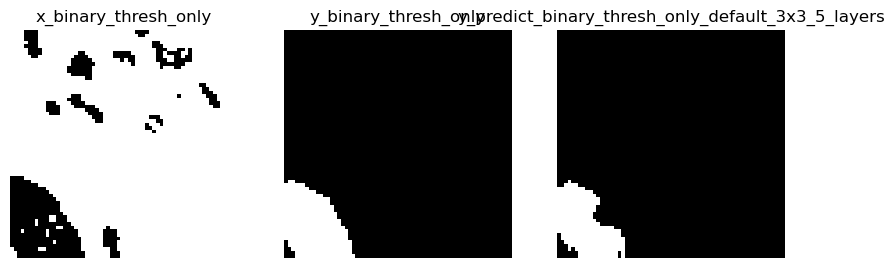

-------binary_thresh_only_mid_3x3_7_layers---------


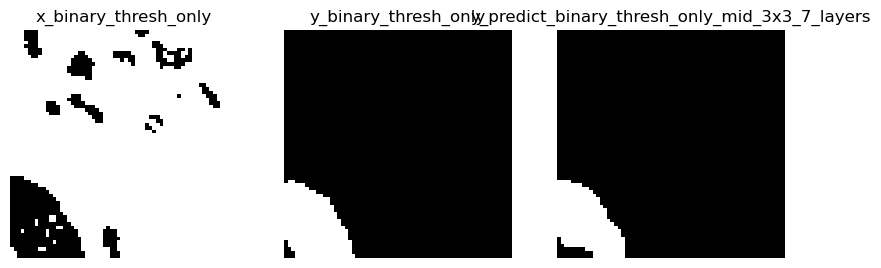

-------binary_thresh_only_high_3x3_9_layers---------


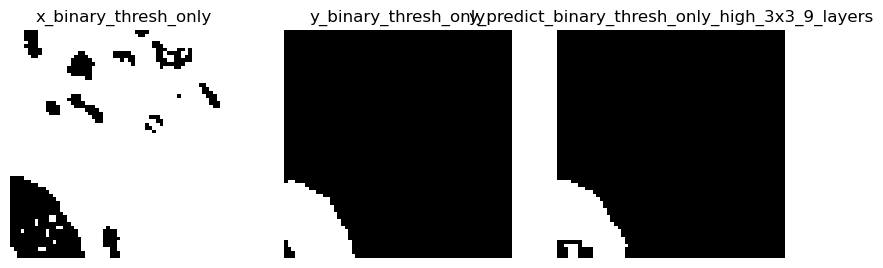

-------binary_thresh_only_default_5x5_5_layers---------


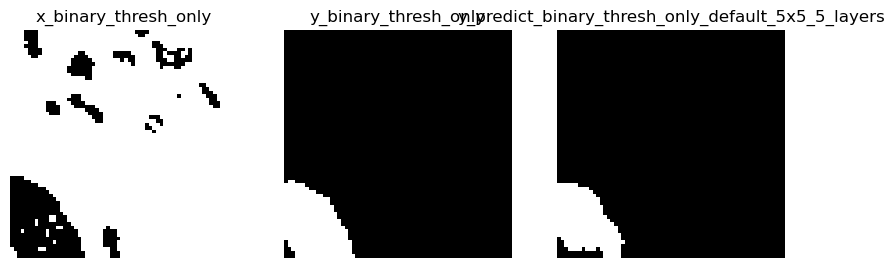

-------binary_thresh_only_mid_5x5_7_layers---------


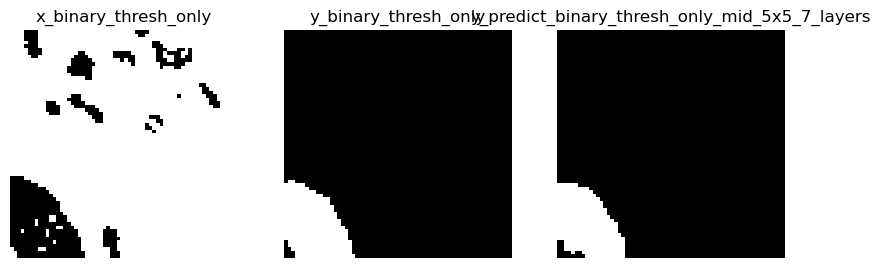

-------binary_thresh_only_high_5x5_9_layers---------


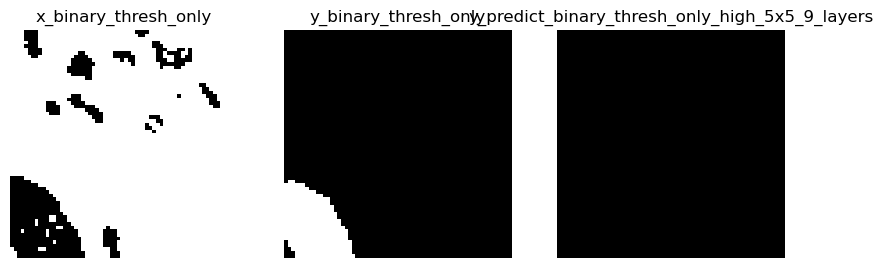

-------hist_eq_and_thresh_default_3x3_5_layers---------


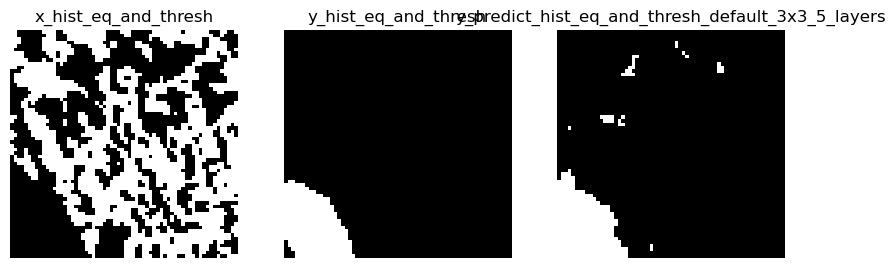

-------hist_eq_and_thresh_mid_3x3_7_layers---------


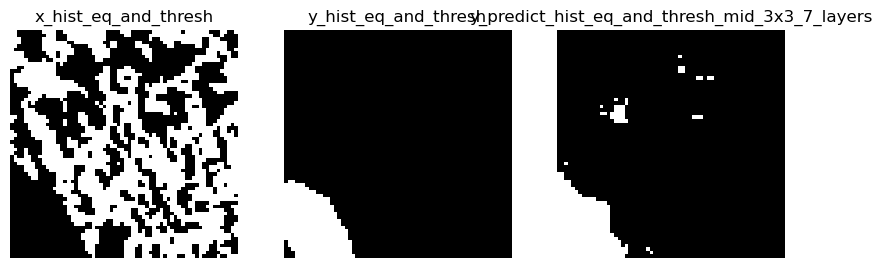

-------hist_eq_and_thresh_high_3x3_9_layers---------


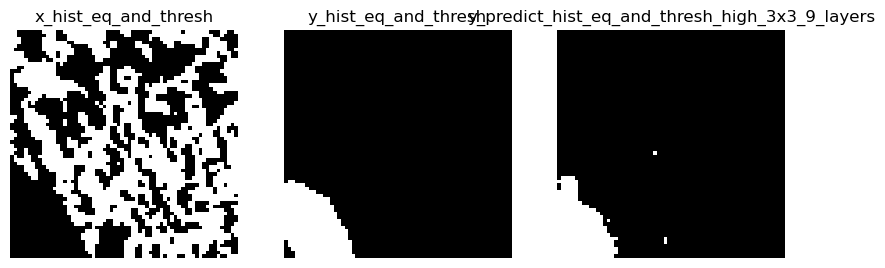

-------hist_eq_and_thresh_default_5x5_5_layers---------


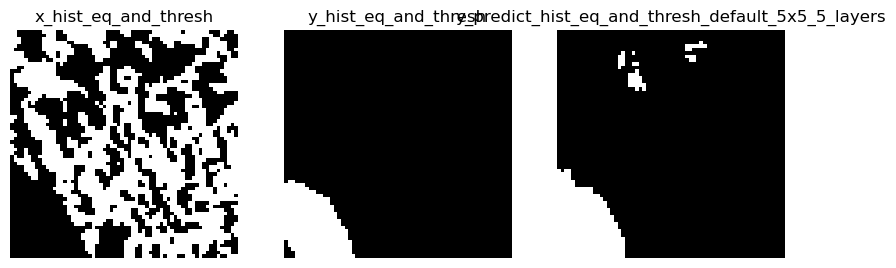

-------hist_eq_and_thresh_mid_5x5_7_layers---------


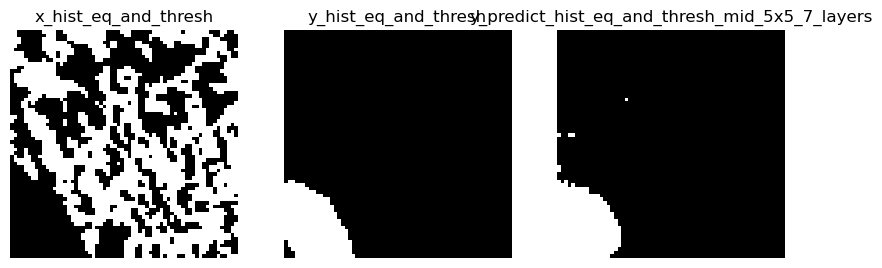

-------hist_eq_and_thresh_high_5x5_9_layers---------


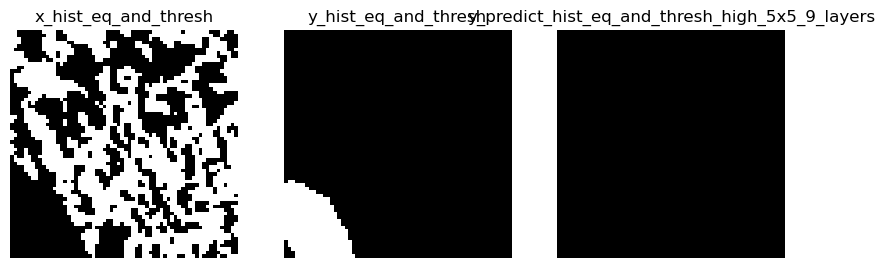

-------invert_default_3x3_5_layers---------


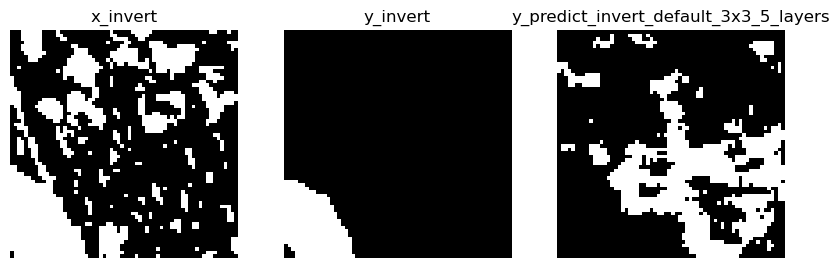

-------invert_mid_3x3_7_layers---------


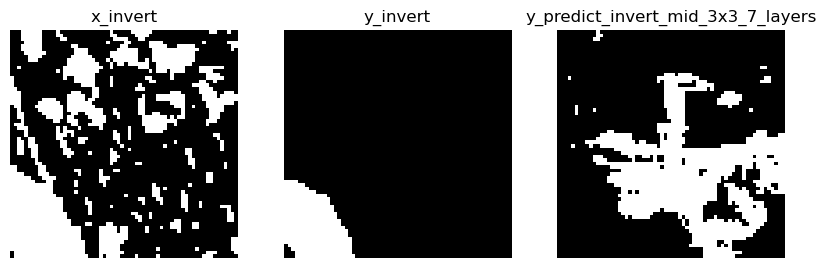

-------invert_high_3x3_9_layers---------


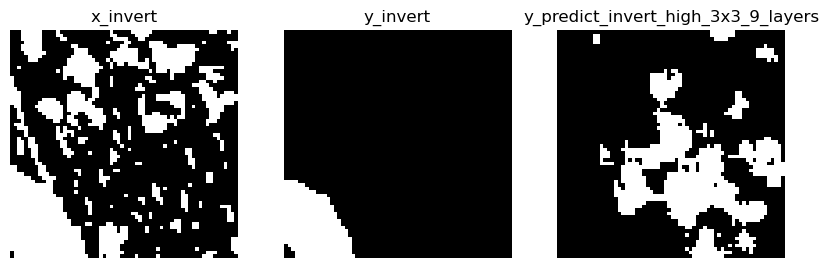

-------invert_default_5x5_5_layers---------


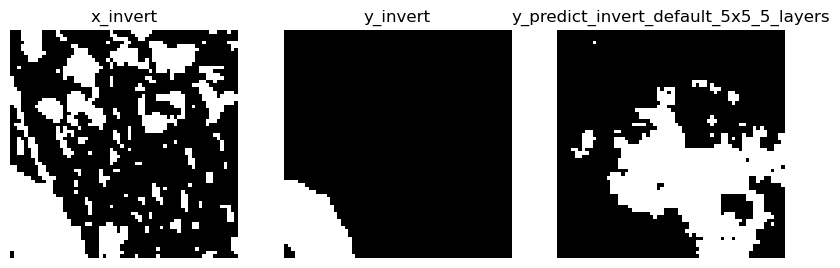

-------invert_mid_5x5_7_layers---------


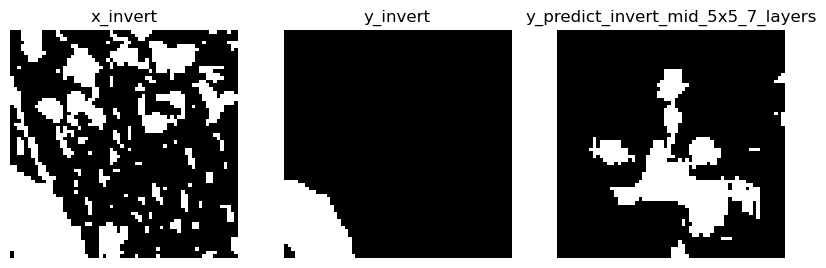

-------invert_high_5x5_9_layers---------


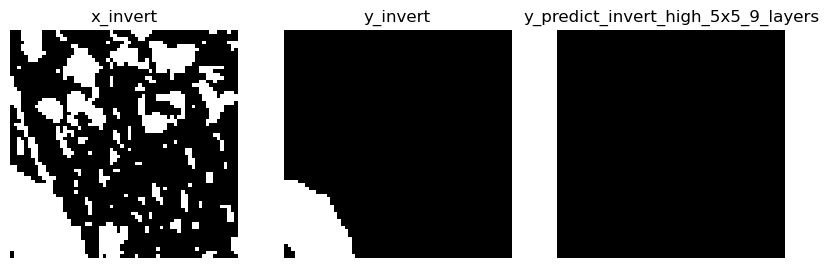

-------full_combo_default_3x3_5_layers---------


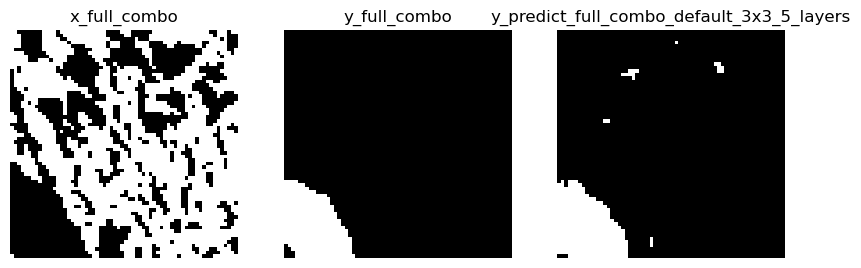

-------full_combo_mid_3x3_7_layers---------


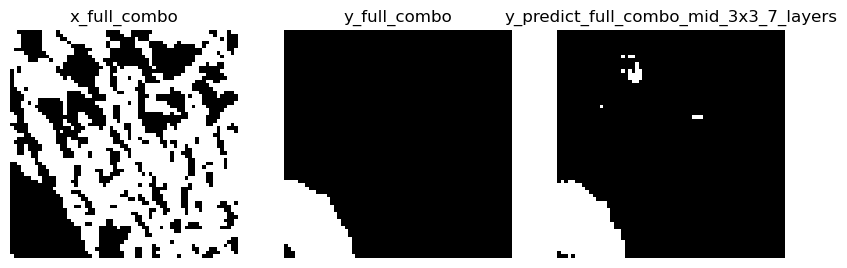

-------full_combo_high_3x3_9_layers---------


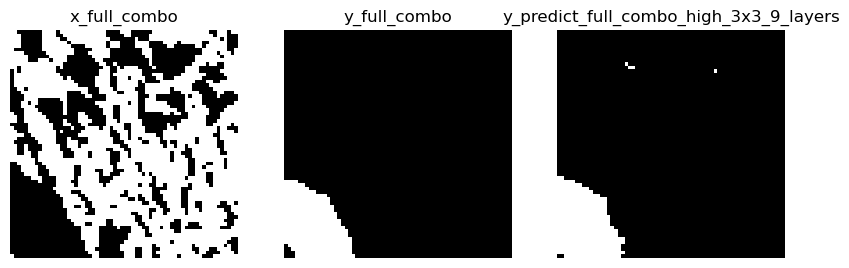

-------full_combo_default_5x5_5_layers---------


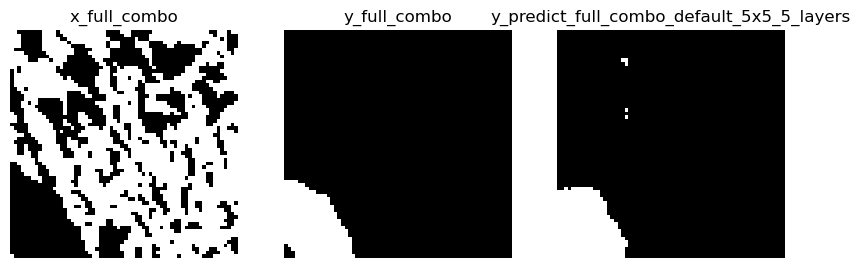

-------full_combo_mid_5x5_7_layers---------


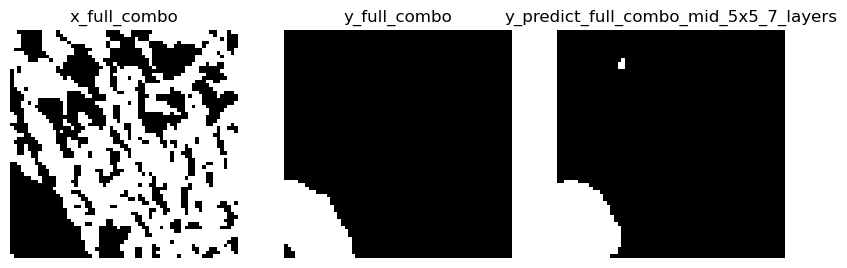

-------full_combo_high_5x5_9_layers---------


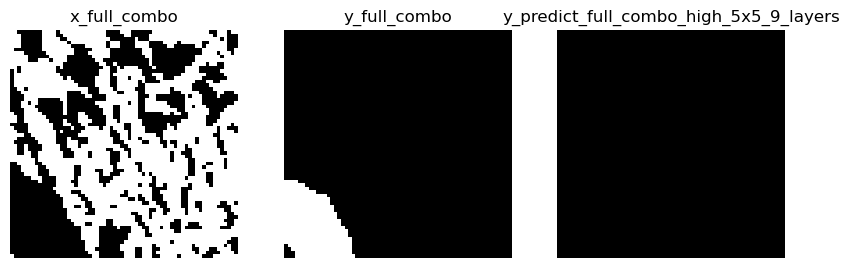

-------binary_thresh_only_default_3x3_5_layers---------


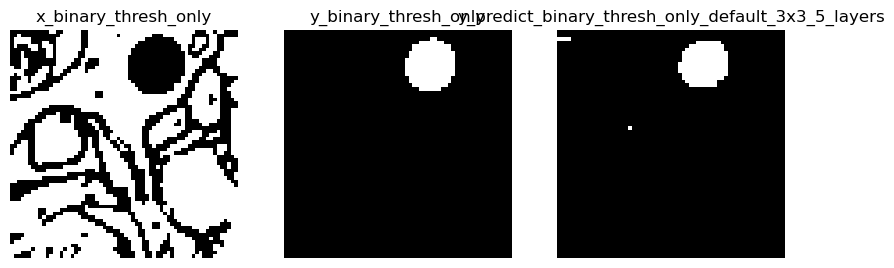

-------binary_thresh_only_mid_3x3_7_layers---------


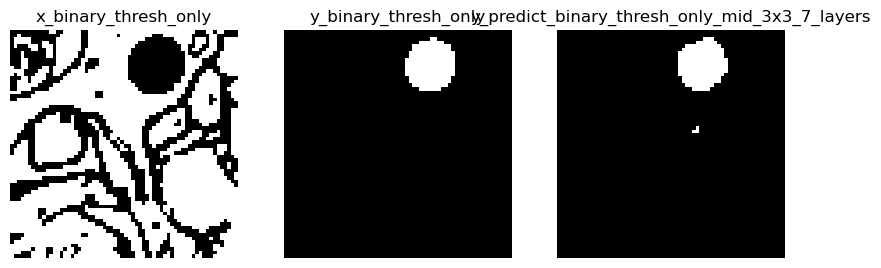

-------binary_thresh_only_high_3x3_9_layers---------


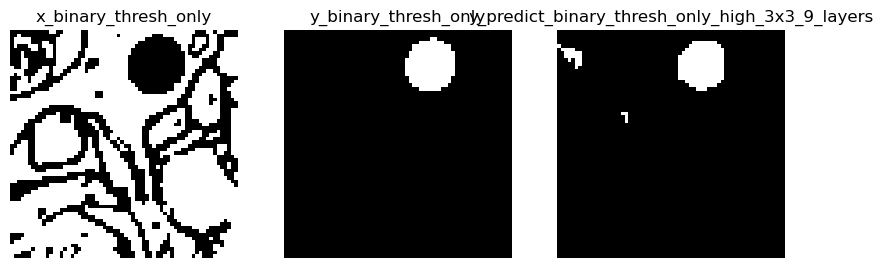

-------binary_thresh_only_default_5x5_5_layers---------


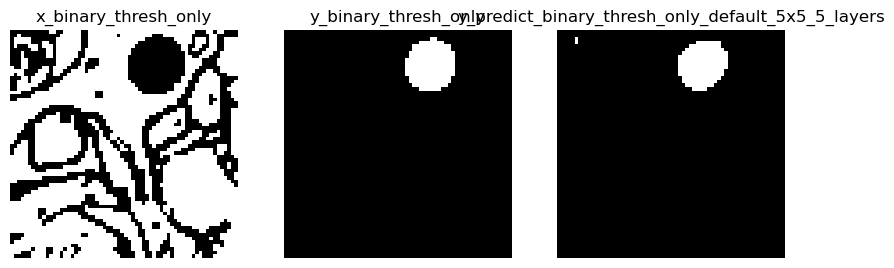

-------binary_thresh_only_mid_5x5_7_layers---------


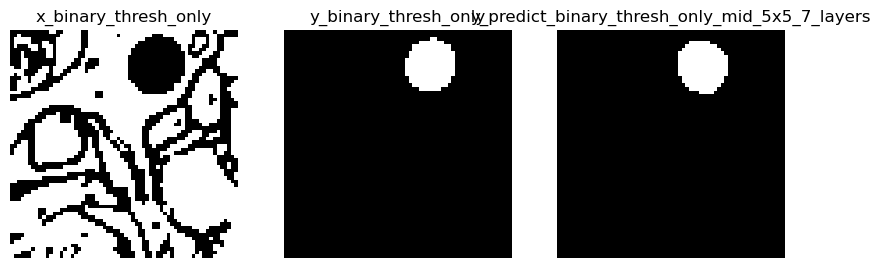

-------binary_thresh_only_high_5x5_9_layers---------


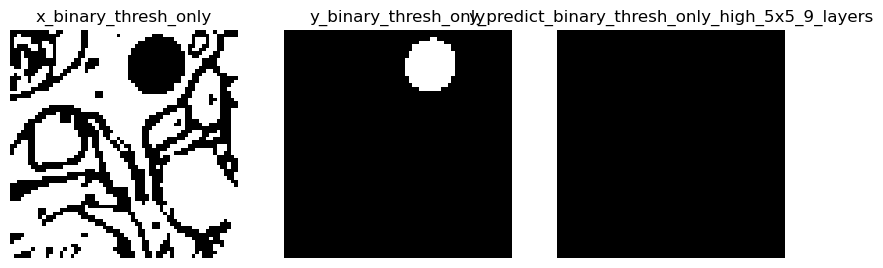

-------hist_eq_and_thresh_default_3x3_5_layers---------


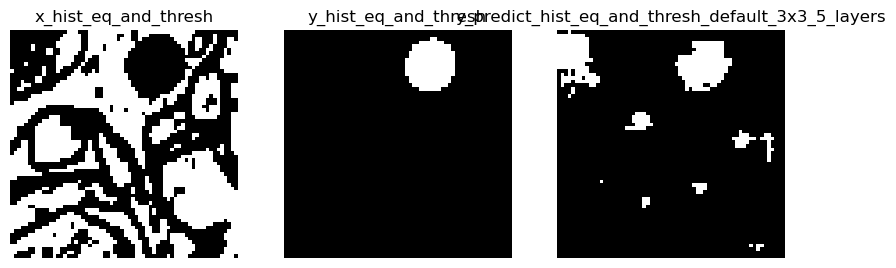

-------hist_eq_and_thresh_mid_3x3_7_layers---------


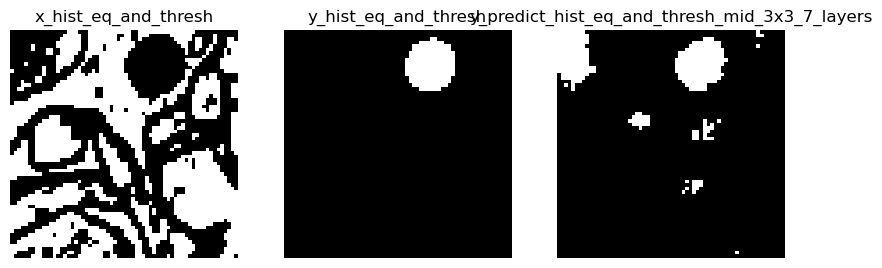

-------hist_eq_and_thresh_high_3x3_9_layers---------


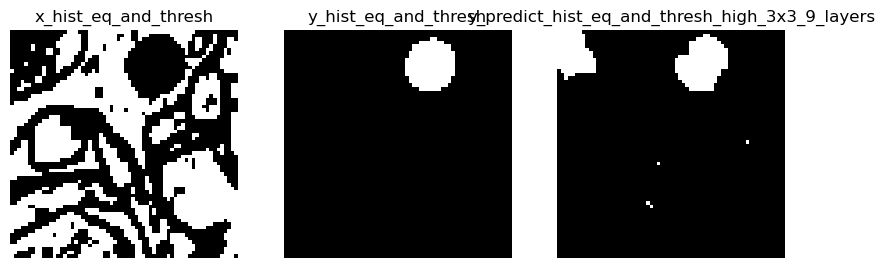

-------hist_eq_and_thresh_default_5x5_5_layers---------


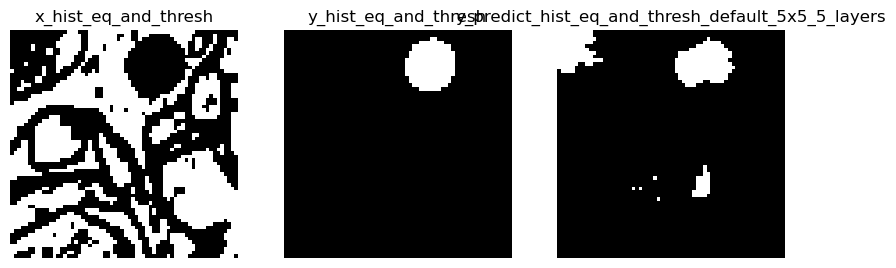

-------hist_eq_and_thresh_mid_5x5_7_layers---------


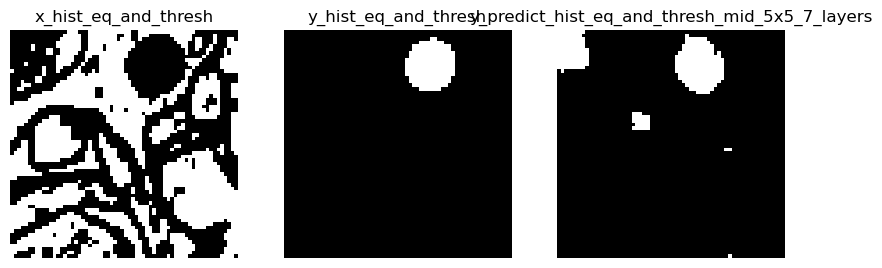

-------hist_eq_and_thresh_high_5x5_9_layers---------


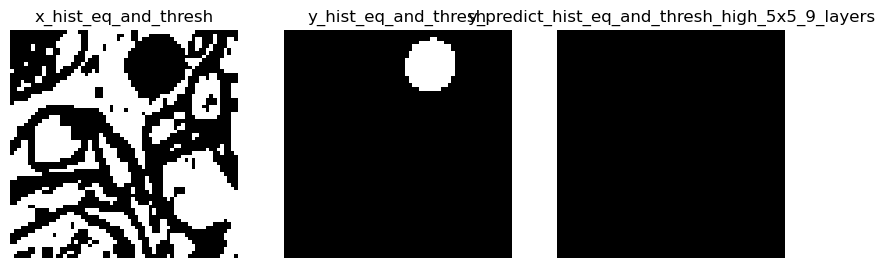

-------invert_default_3x3_5_layers---------


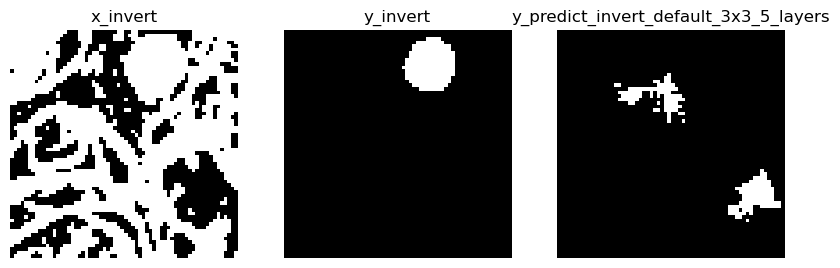

-------invert_mid_3x3_7_layers---------


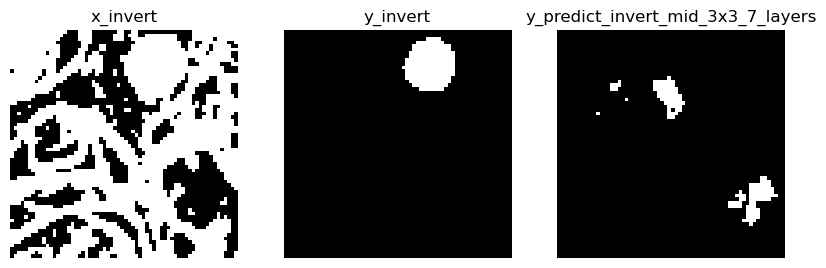

-------invert_high_3x3_9_layers---------


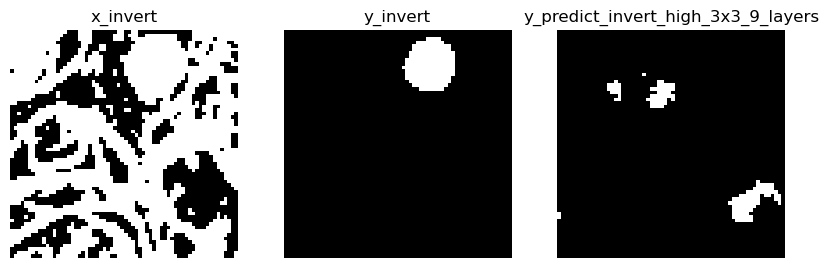

-------invert_default_5x5_5_layers---------


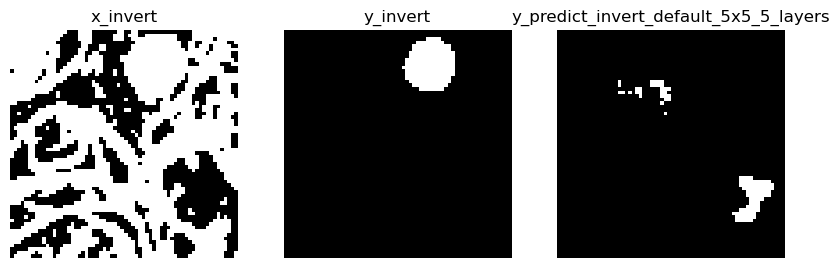

-------invert_mid_5x5_7_layers---------


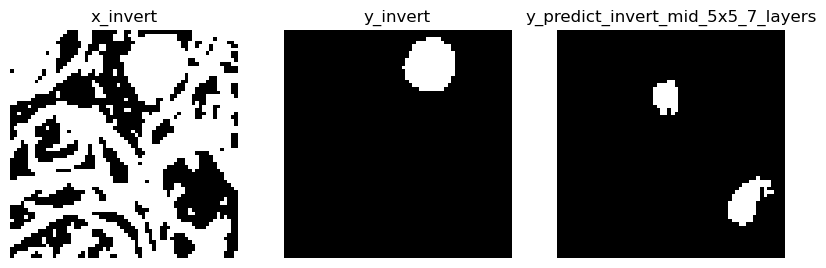

-------invert_high_5x5_9_layers---------


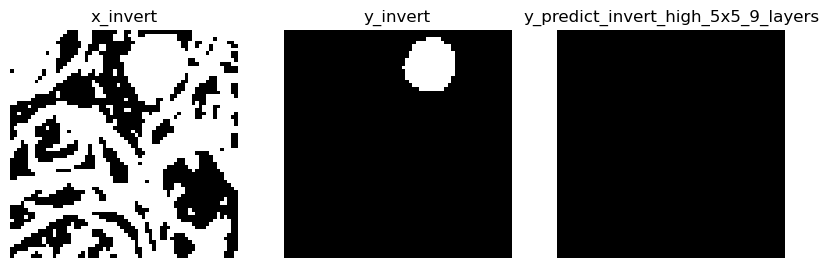

-------full_combo_default_3x3_5_layers---------


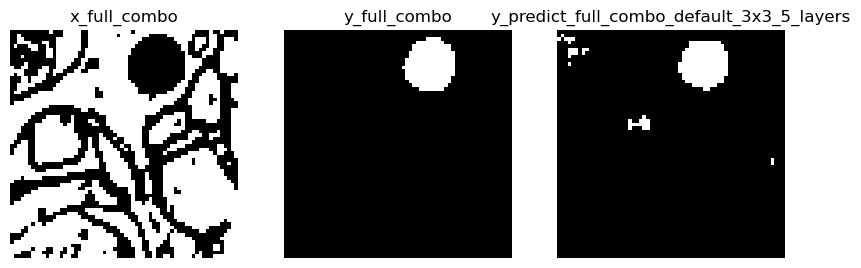

-------full_combo_mid_3x3_7_layers---------


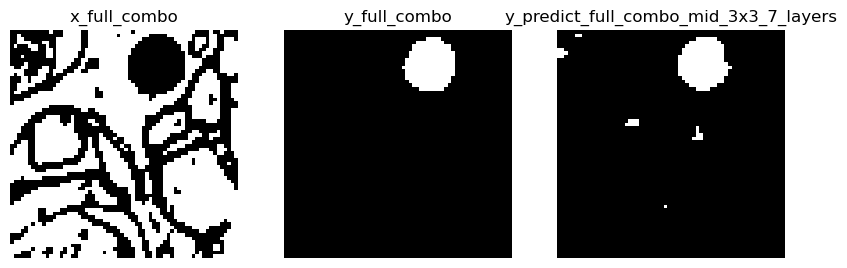

-------full_combo_high_3x3_9_layers---------


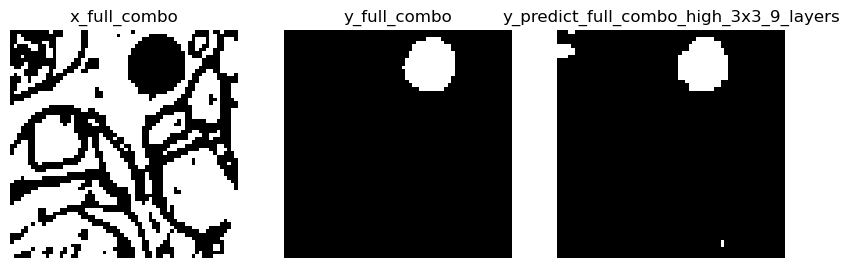

-------full_combo_default_5x5_5_layers---------


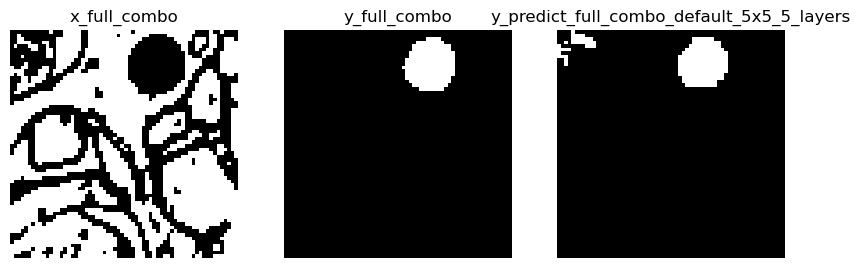

-------full_combo_mid_5x5_7_layers---------


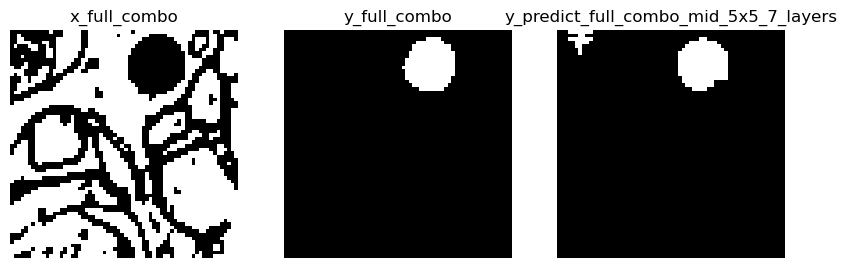

-------full_combo_high_5x5_9_layers---------


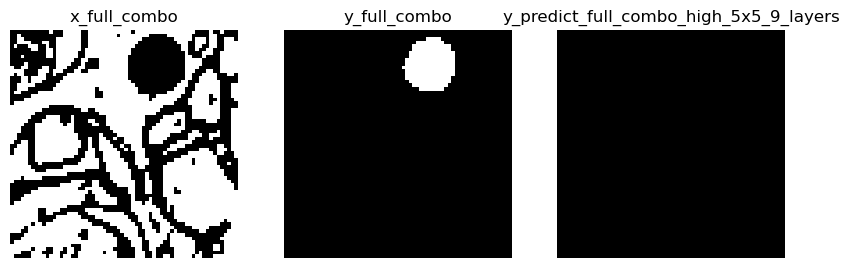

-------binary_thresh_only_default_3x3_5_layers---------


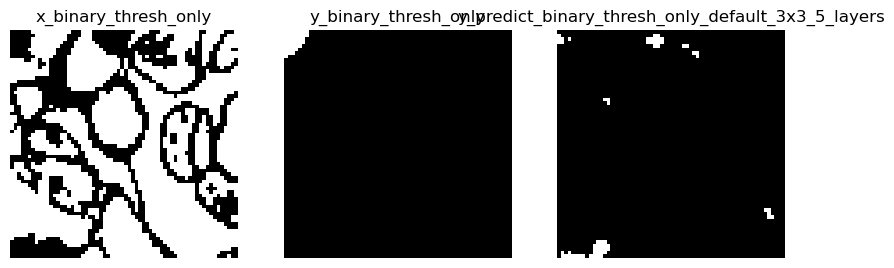

-------binary_thresh_only_mid_3x3_7_layers---------


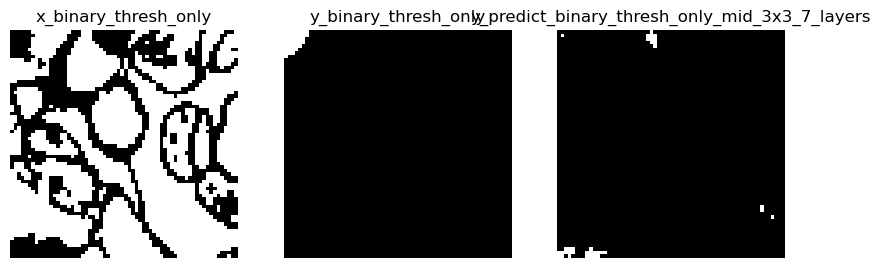

-------binary_thresh_only_high_3x3_9_layers---------


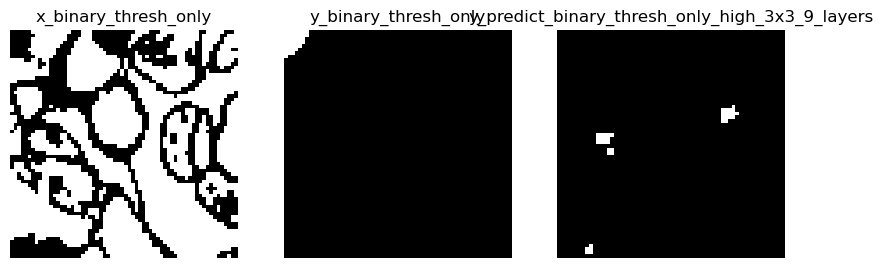

-------binary_thresh_only_default_5x5_5_layers---------


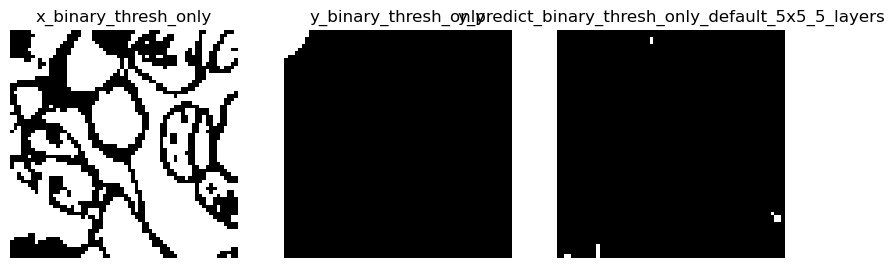

-------binary_thresh_only_mid_5x5_7_layers---------


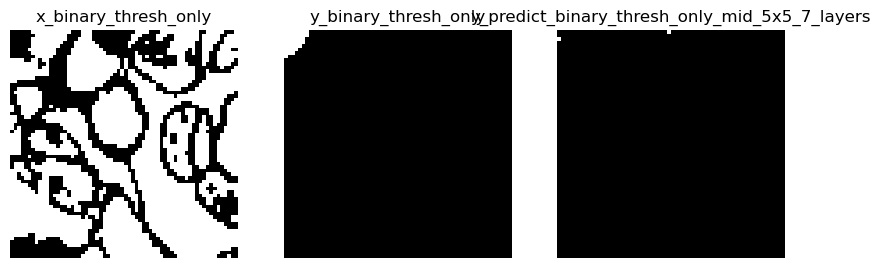

-------binary_thresh_only_high_5x5_9_layers---------


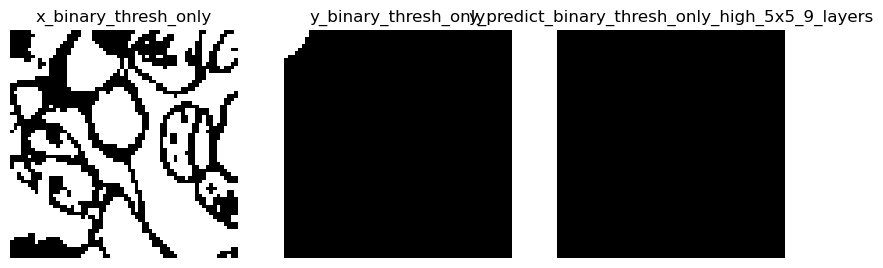

-------hist_eq_and_thresh_default_3x3_5_layers---------


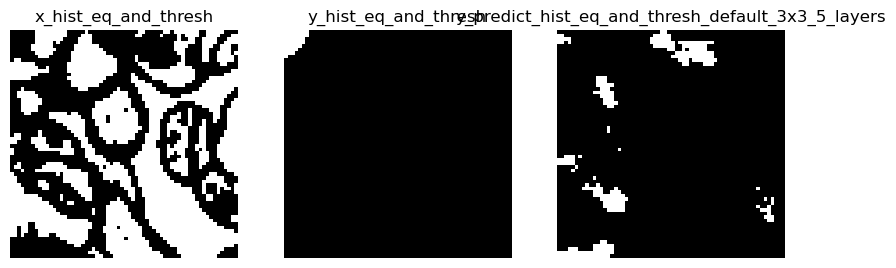

-------hist_eq_and_thresh_mid_3x3_7_layers---------


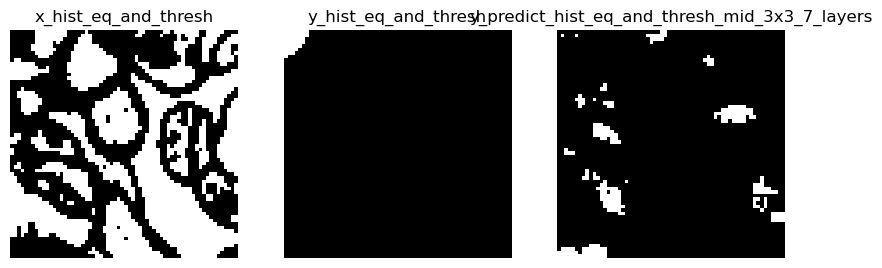

-------hist_eq_and_thresh_high_3x3_9_layers---------


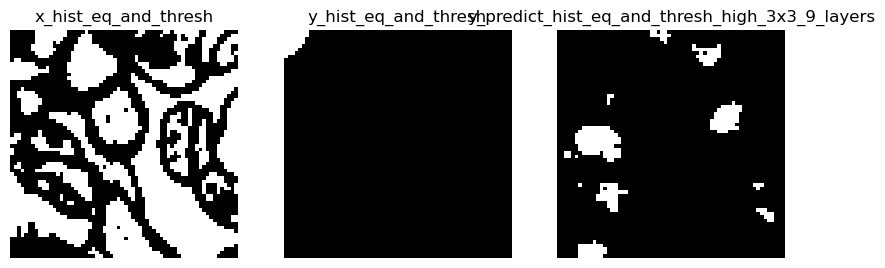

-------hist_eq_and_thresh_default_5x5_5_layers---------


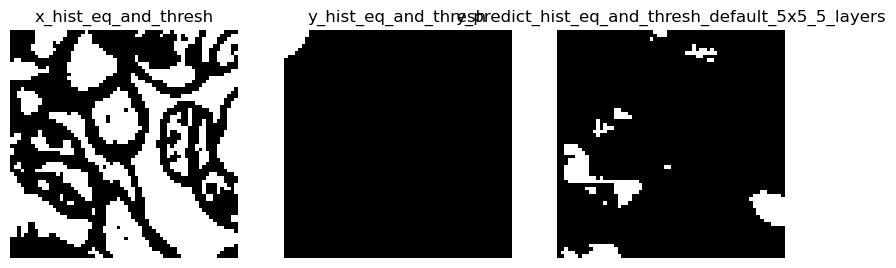

-------hist_eq_and_thresh_mid_5x5_7_layers---------


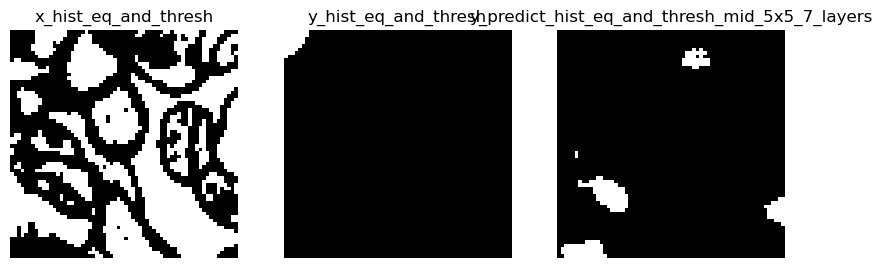

-------hist_eq_and_thresh_high_5x5_9_layers---------


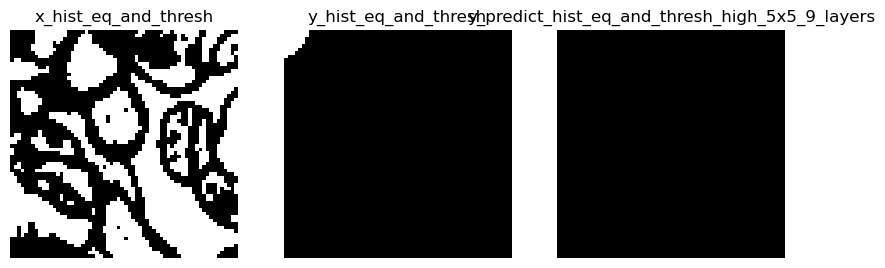

-------invert_default_3x3_5_layers---------


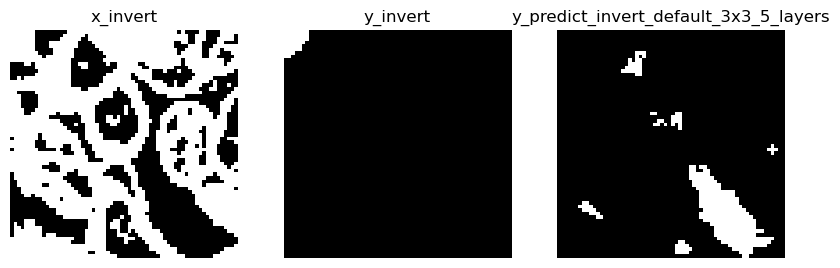

-------invert_mid_3x3_7_layers---------


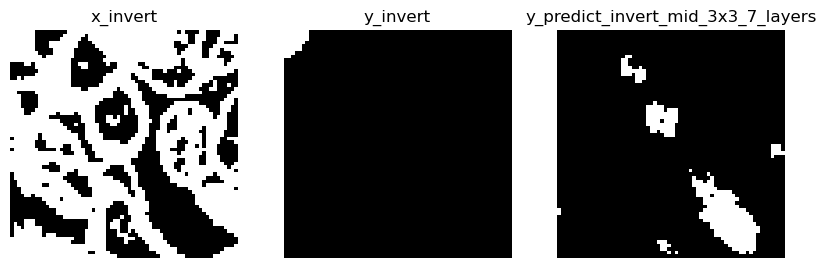

-------invert_high_3x3_9_layers---------


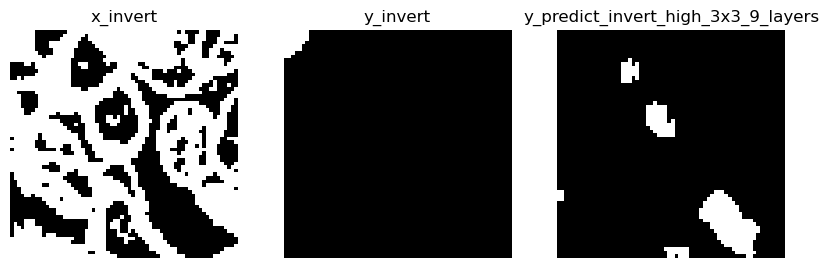

-------invert_default_5x5_5_layers---------


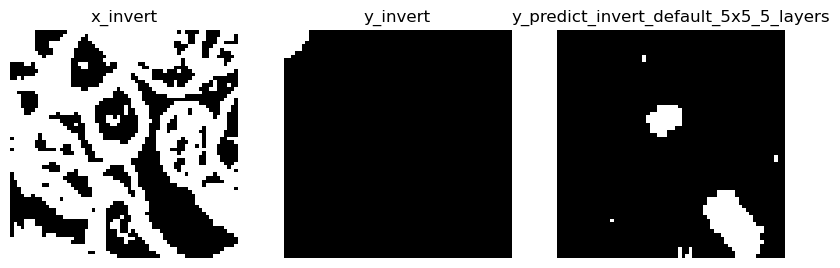

-------invert_mid_5x5_7_layers---------


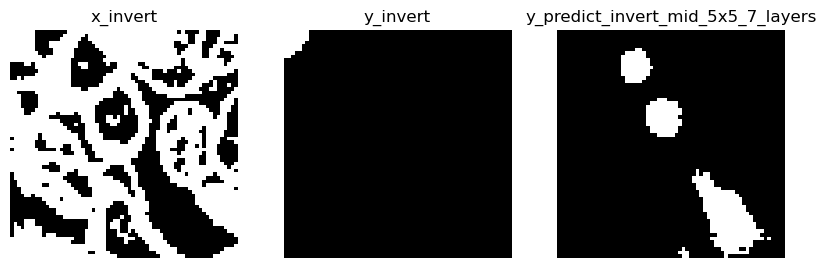

-------invert_high_5x5_9_layers---------


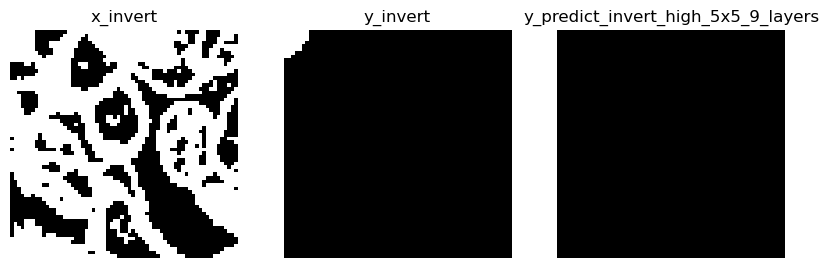

-------full_combo_default_3x3_5_layers---------


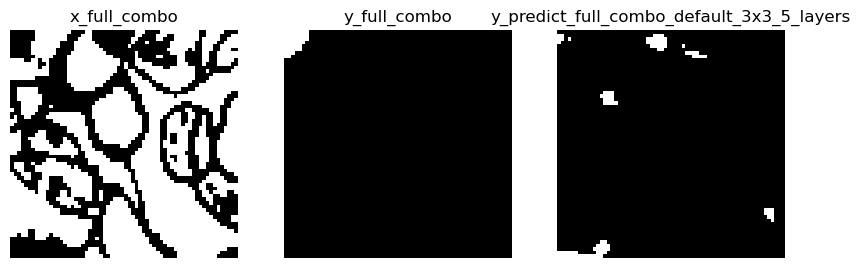

-------full_combo_mid_3x3_7_layers---------


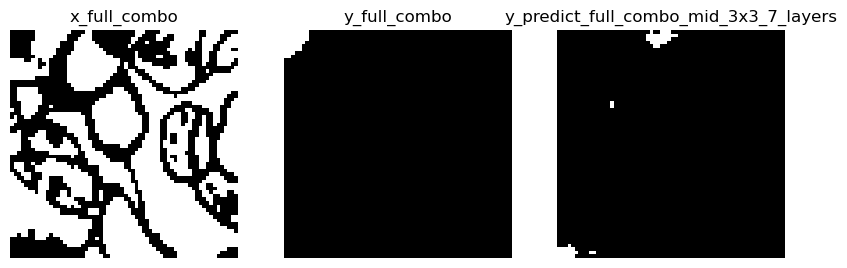

-------full_combo_high_3x3_9_layers---------


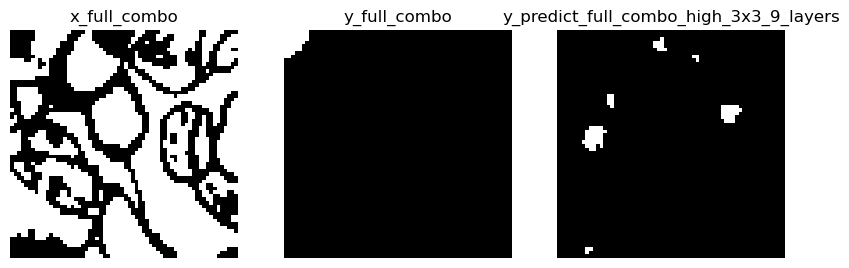

-------full_combo_default_5x5_5_layers---------


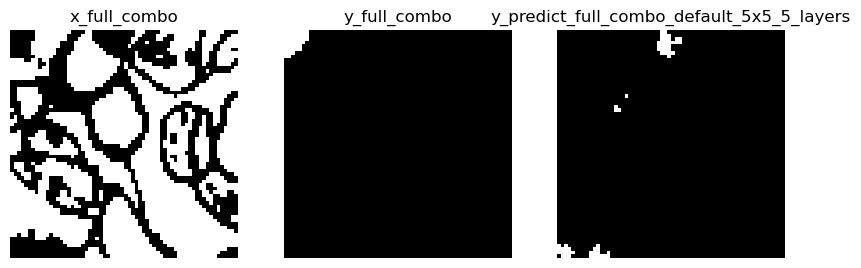

-------full_combo_mid_5x5_7_layers---------


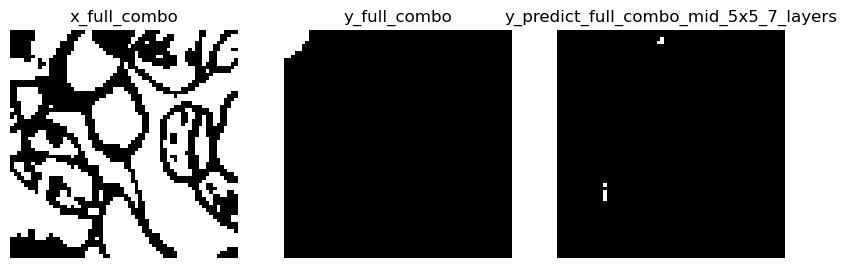

-------full_combo_high_5x5_9_layers---------


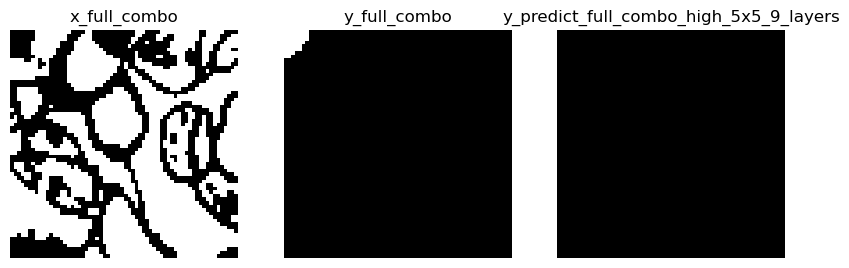

-------binary_thresh_only_default_3x3_5_layers---------


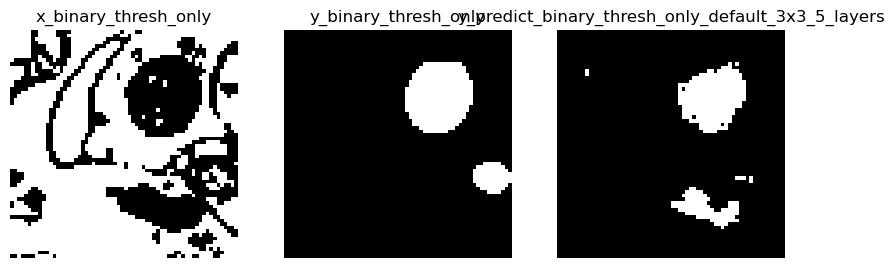

-------binary_thresh_only_mid_3x3_7_layers---------


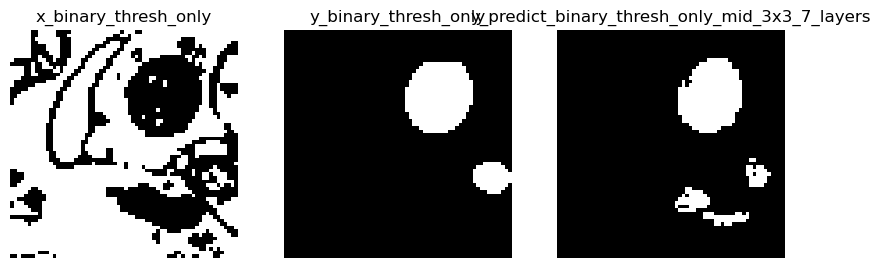

-------binary_thresh_only_high_3x3_9_layers---------


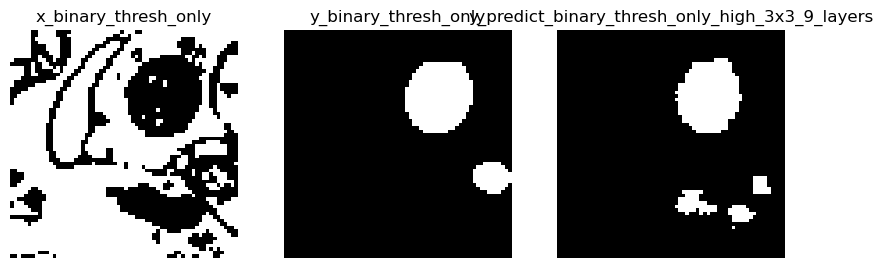

-------binary_thresh_only_default_5x5_5_layers---------


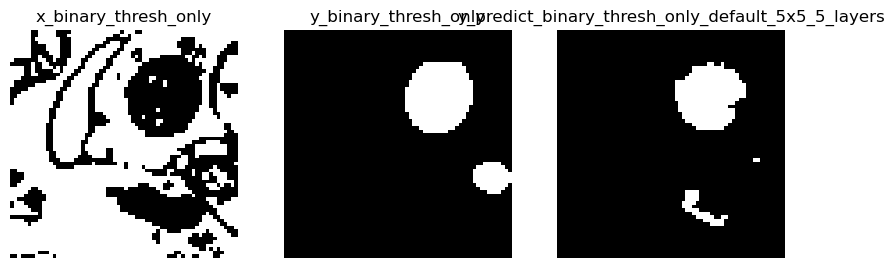

-------binary_thresh_only_mid_5x5_7_layers---------


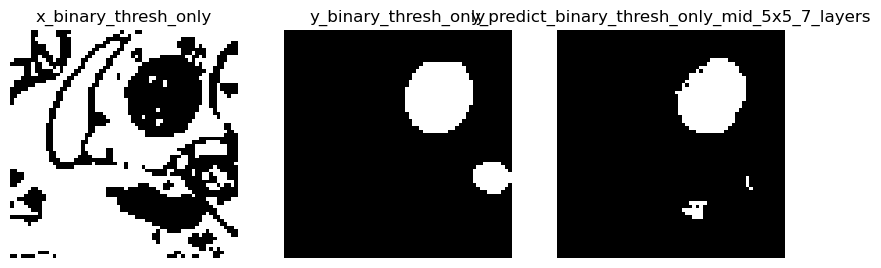

-------binary_thresh_only_high_5x5_9_layers---------


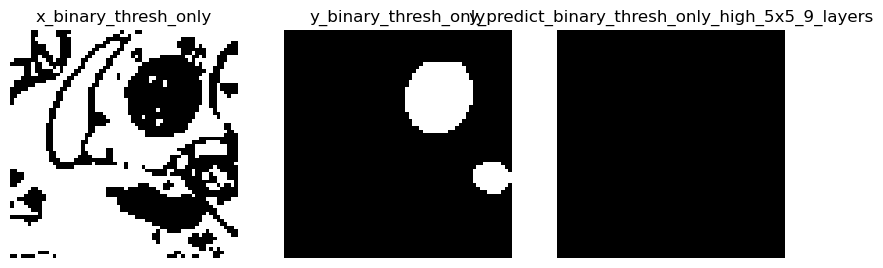

-------hist_eq_and_thresh_default_3x3_5_layers---------


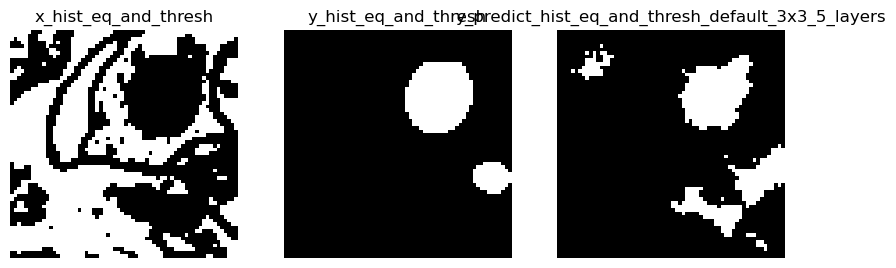

-------hist_eq_and_thresh_mid_3x3_7_layers---------


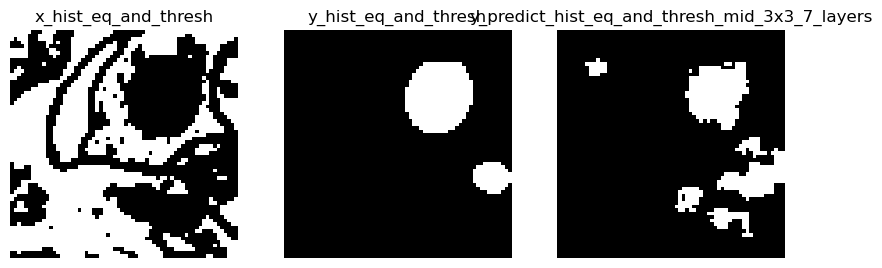

-------hist_eq_and_thresh_high_3x3_9_layers---------


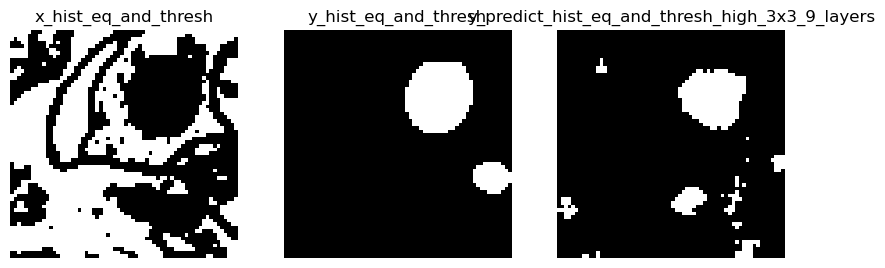

-------hist_eq_and_thresh_default_5x5_5_layers---------


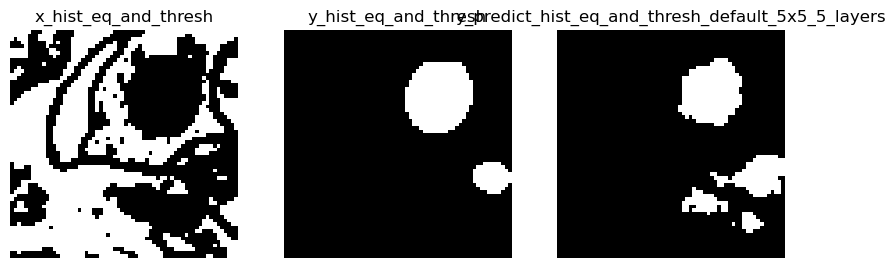

-------hist_eq_and_thresh_mid_5x5_7_layers---------


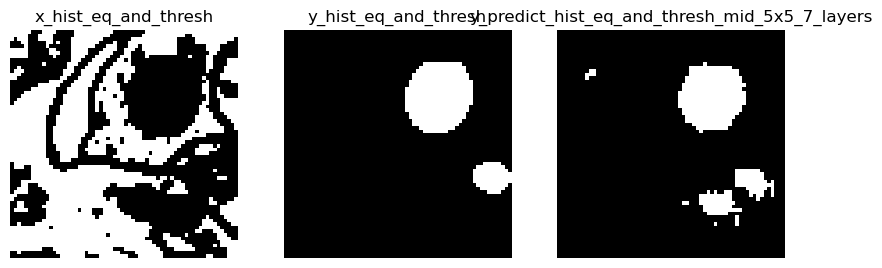

-------hist_eq_and_thresh_high_5x5_9_layers---------


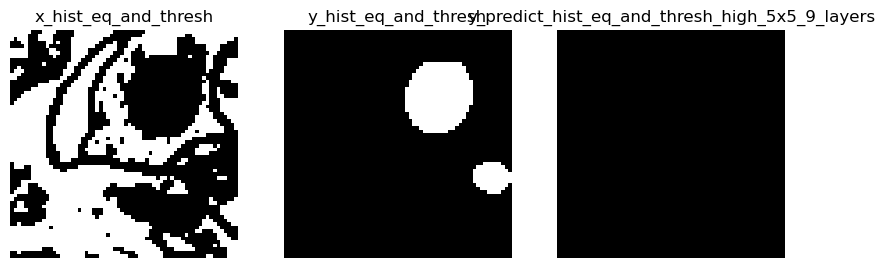

-------invert_default_3x3_5_layers---------


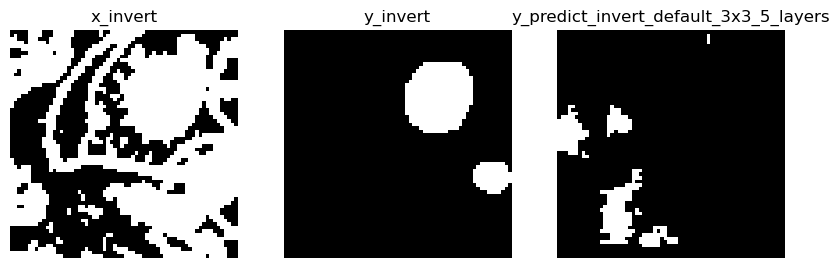

-------invert_mid_3x3_7_layers---------


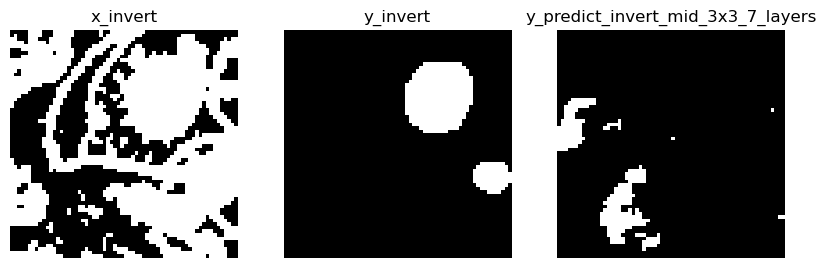

-------invert_high_3x3_9_layers---------


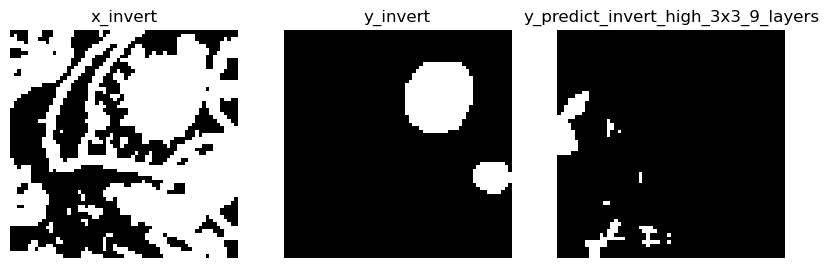

-------invert_default_5x5_5_layers---------


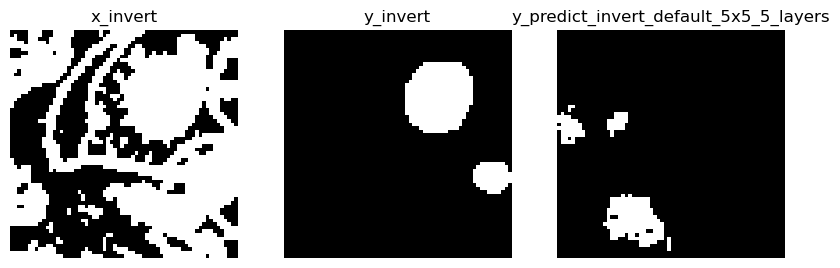

-------invert_mid_5x5_7_layers---------


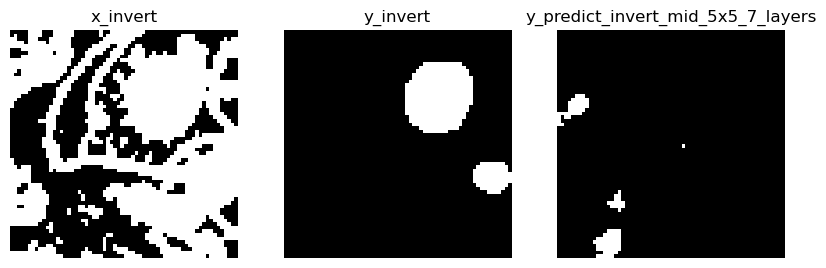

-------invert_high_5x5_9_layers---------


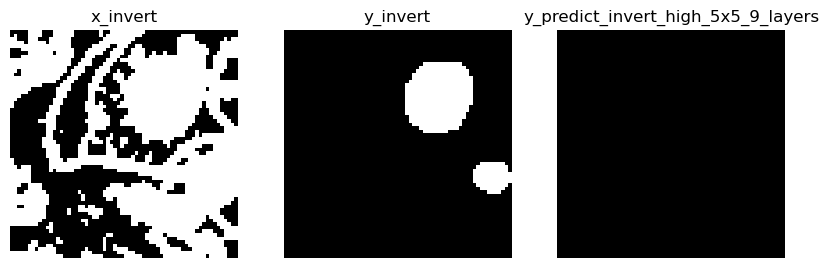

-------full_combo_default_3x3_5_layers---------


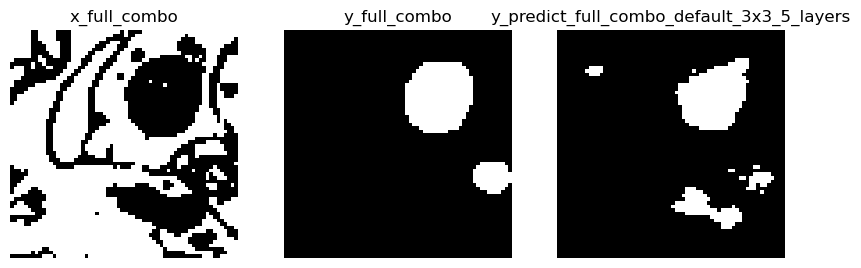

-------full_combo_mid_3x3_7_layers---------


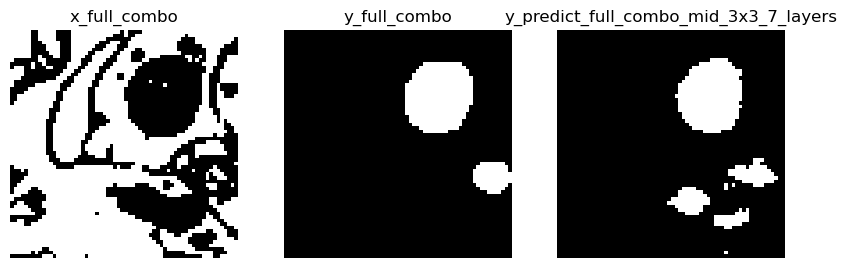

-------full_combo_high_3x3_9_layers---------


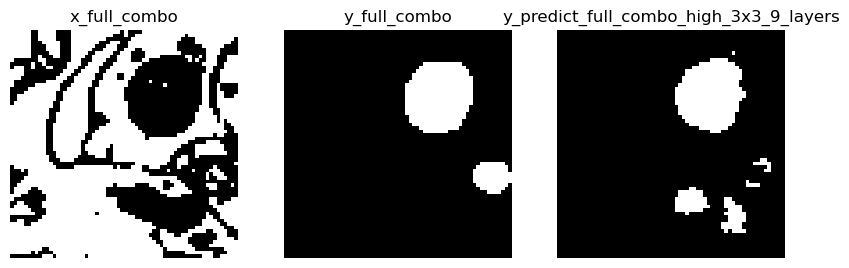

-------full_combo_default_5x5_5_layers---------


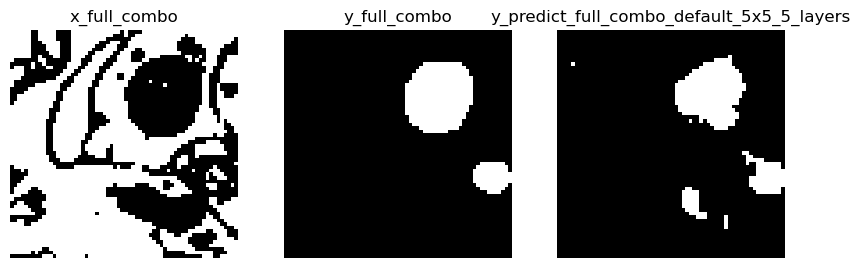

-------full_combo_mid_5x5_7_layers---------


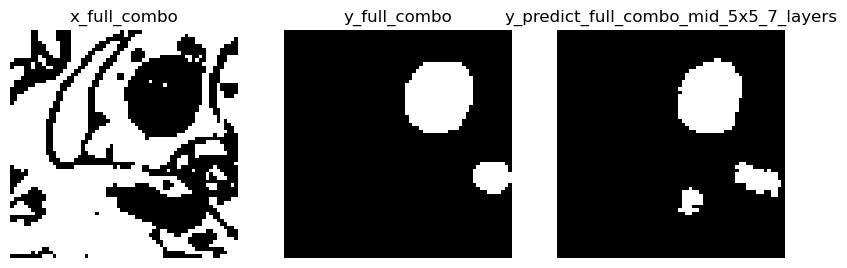

-------full_combo_high_5x5_9_layers---------


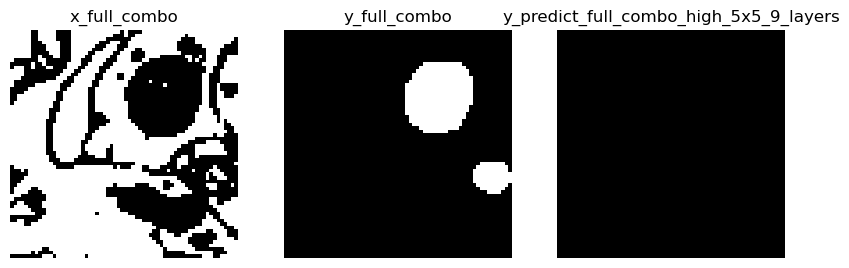

-------binary_thresh_only_default_3x3_5_layers---------


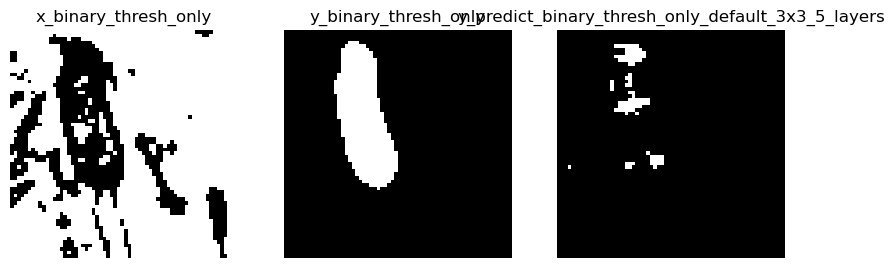

-------binary_thresh_only_mid_3x3_7_layers---------


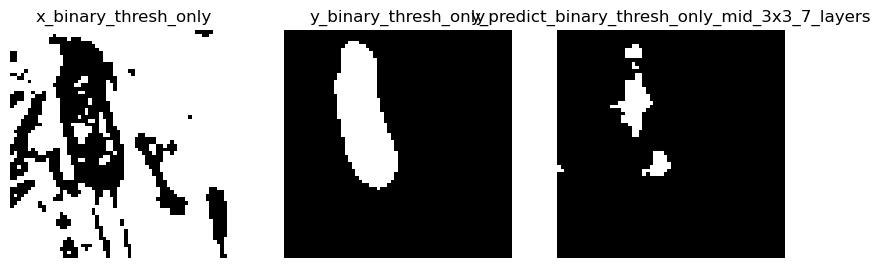

-------binary_thresh_only_high_3x3_9_layers---------


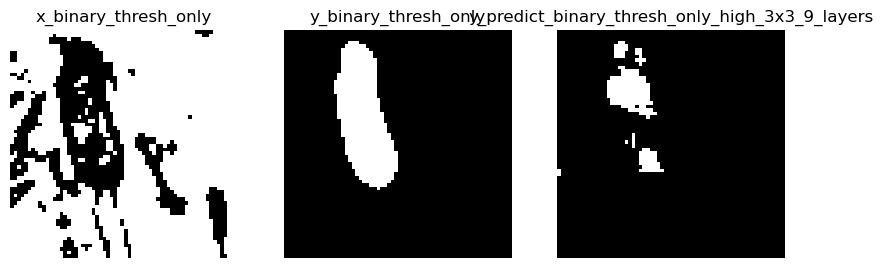

-------binary_thresh_only_default_5x5_5_layers---------


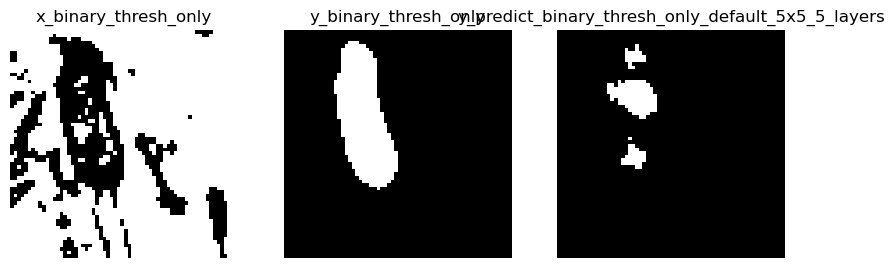

-------binary_thresh_only_mid_5x5_7_layers---------


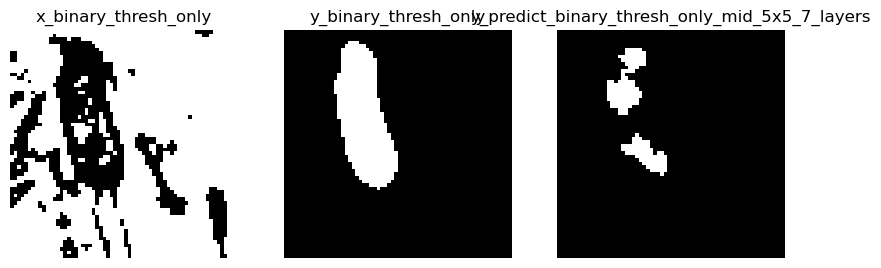

-------binary_thresh_only_high_5x5_9_layers---------


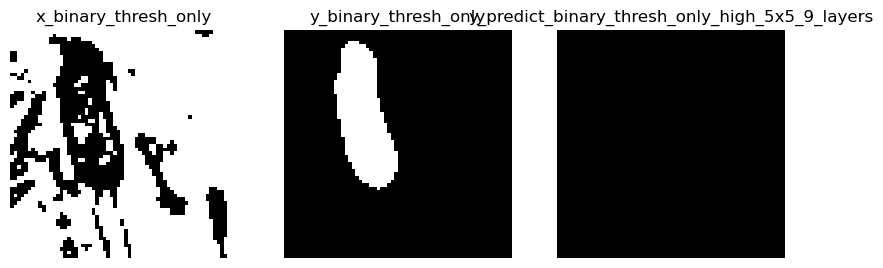

-------hist_eq_and_thresh_default_3x3_5_layers---------


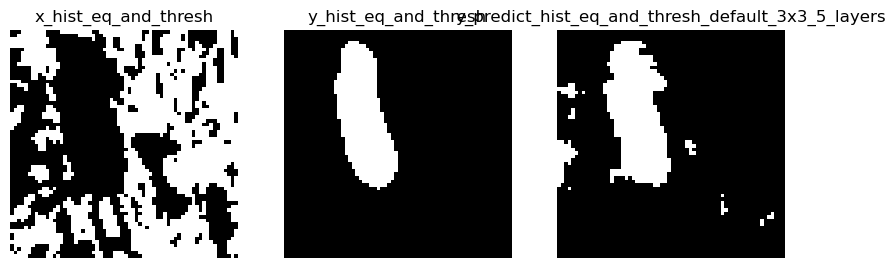

-------hist_eq_and_thresh_mid_3x3_7_layers---------


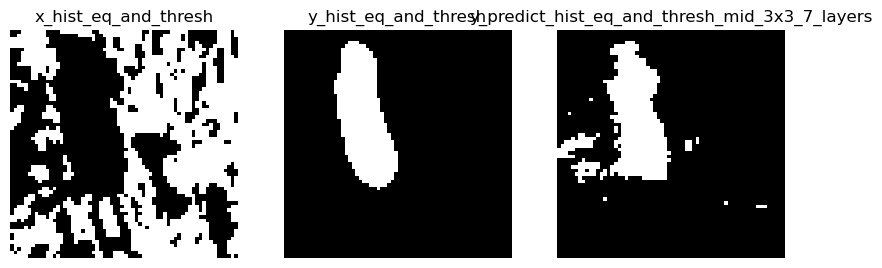

-------hist_eq_and_thresh_high_3x3_9_layers---------


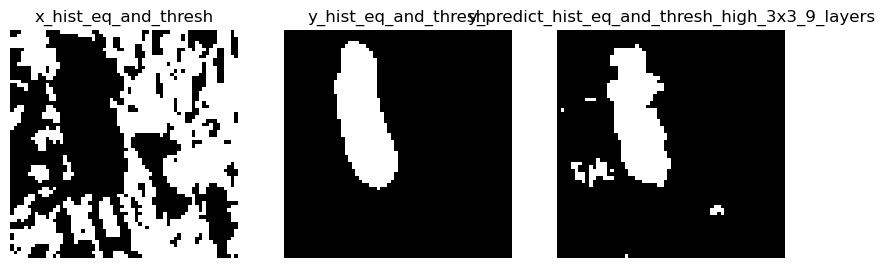

-------hist_eq_and_thresh_default_5x5_5_layers---------


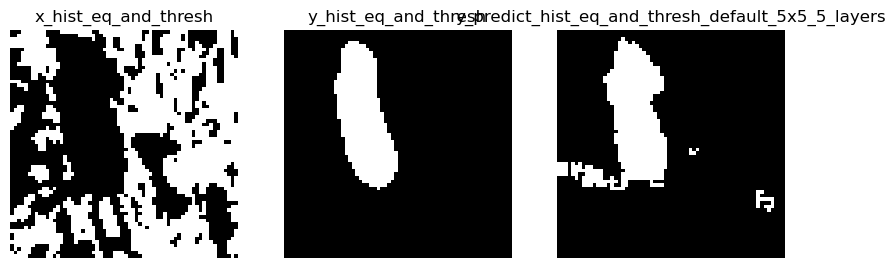

-------hist_eq_and_thresh_mid_5x5_7_layers---------


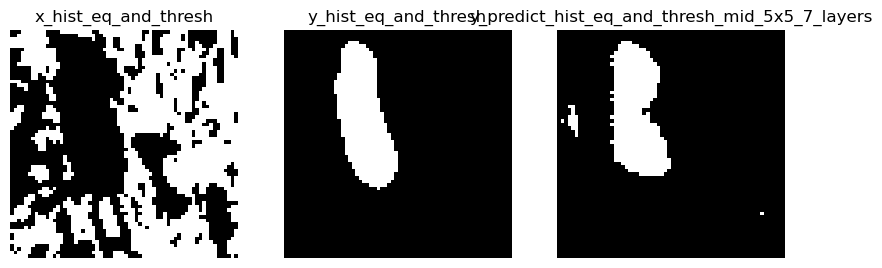

-------hist_eq_and_thresh_high_5x5_9_layers---------


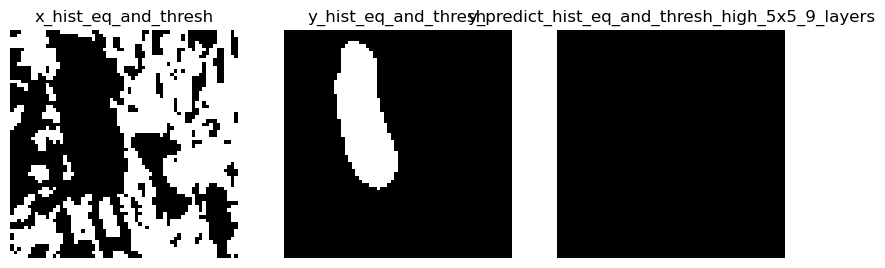

-------invert_default_3x3_5_layers---------


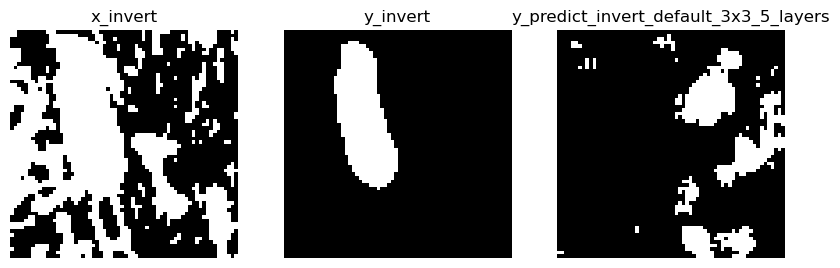

-------invert_mid_3x3_7_layers---------


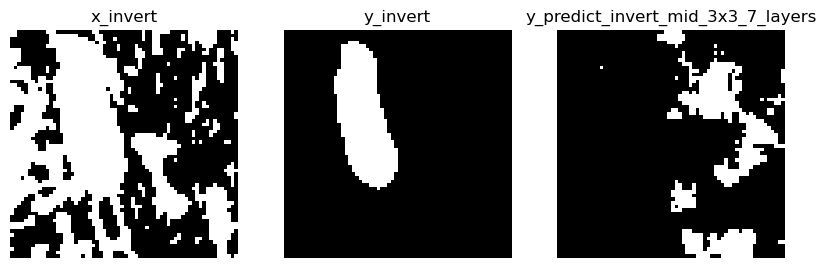

-------invert_high_3x3_9_layers---------


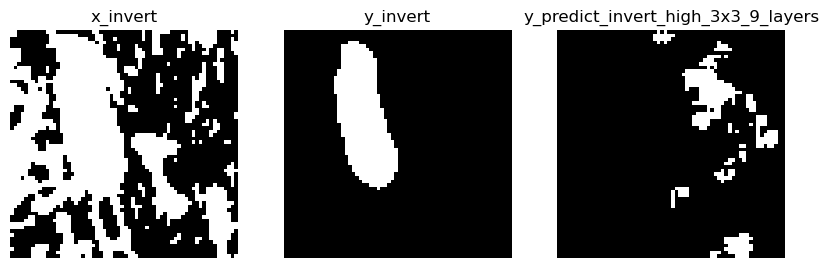

-------invert_default_5x5_5_layers---------


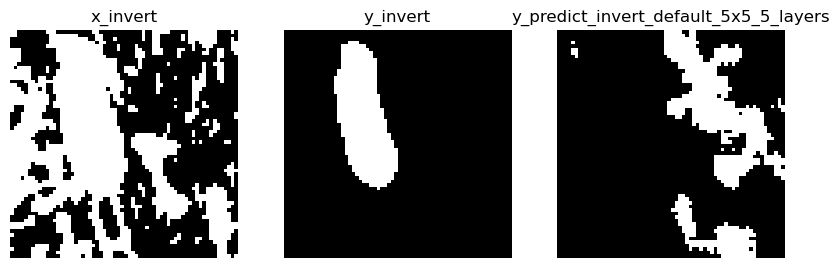

-------invert_mid_5x5_7_layers---------


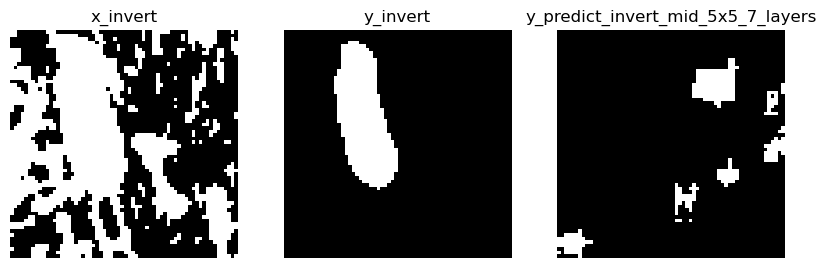

-------invert_high_5x5_9_layers---------


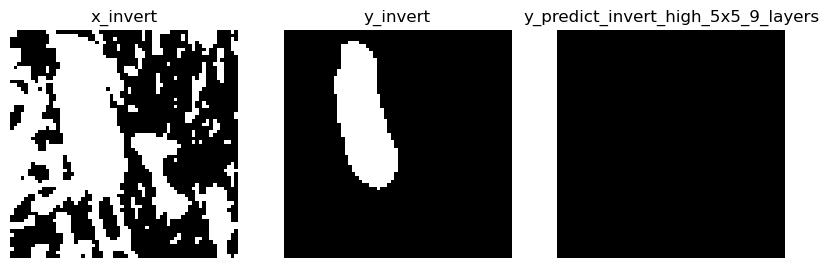

-------full_combo_default_3x3_5_layers---------


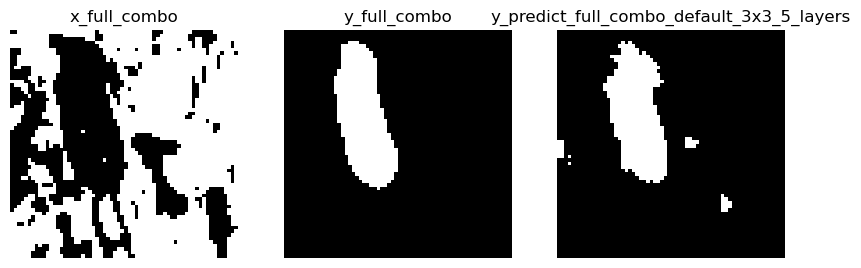

-------full_combo_mid_3x3_7_layers---------


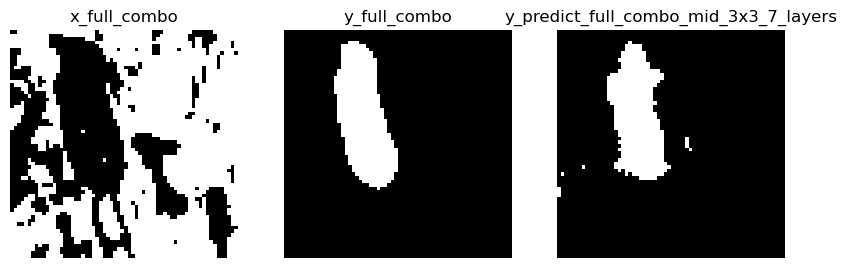

-------full_combo_high_3x3_9_layers---------


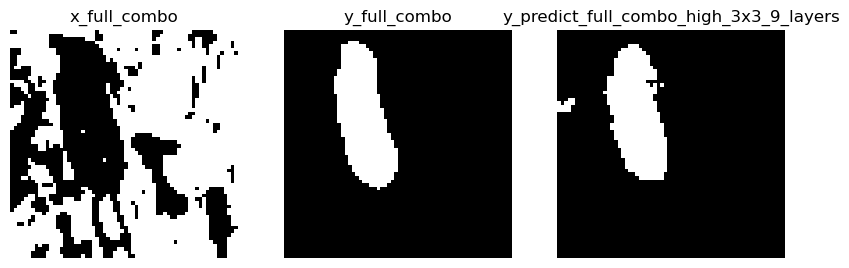

-------full_combo_default_5x5_5_layers---------


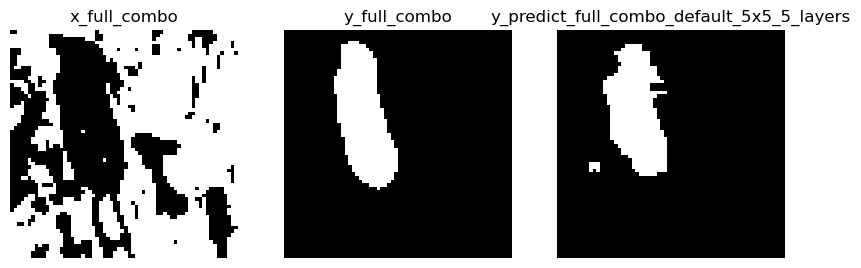

-------full_combo_mid_5x5_7_layers---------


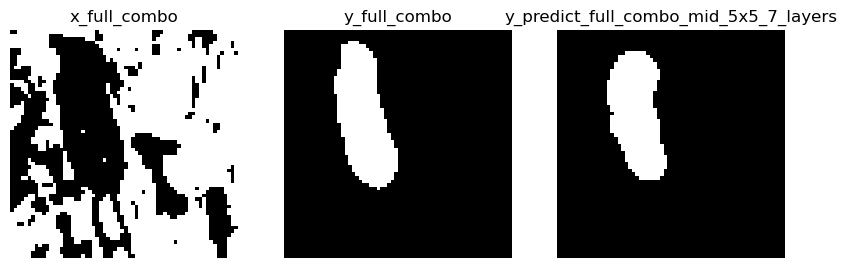

-------full_combo_high_5x5_9_layers---------


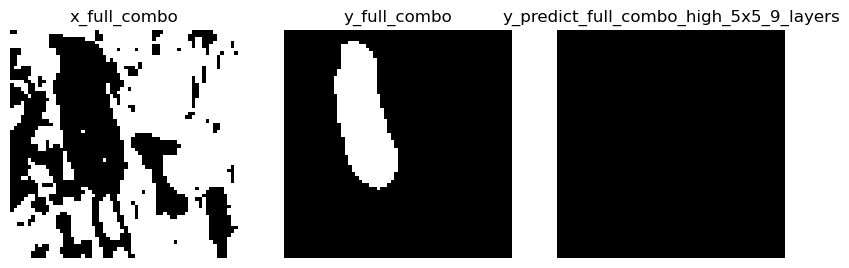

In [28]:
for i in range(5):
    pipeline_terminal.display_sample_predictions(i, train=False)